# 🧠 **Lecture 3 — From First Principles to a Production-Ready ML Pipeline**

> **Note:**
> This notebook is intentionally kept **minimal**.
> Its purpose is to **introduce the full lifecycle** of building a machine learning model — from raw data to production deployment.
> The *actual implementations* live in a modular Python package located in the same directory.

---

## 🎯 **Learning Objectives**

By the end of this session, you will:

1. **Load & preprocess raw datasets manually**
   – No high-level libraries, no shortcuts.

2. **Train & stress-test nine DNN models**
   – 3 architectures × 3 datasets = **9 experiments**.

3. **Visualize the complete training dynamics**
   – Loss curves, accuracy curves, and per-epoch diagnostics.

4. **Design a production-ready ML pipeline**
   – Modular architecture, clean abstractions, reusable components.

5. **Deploy an interactive UI for model comparison**
   – Side-by-side evaluation of all trained models.

---

## 🧭 **Experiment Matrix — 3×3 Grid**

| **Architecture \ Dataset**       | **MNIST** | **Fashion-MNIST** | **CIFAR-10** |
| -------------------------------- | --------- | ----------------- | ------------ |
| **Simple DNN** (1 hidden layer)  | Model 1   | Model 2           | Model 3      |
| **Medium DNN** (2 hidden layers) | Model 4   | Model 5           | Model 6      |
| **Deep DNN** (3 hidden layers)   | Model 7   | Model 8           | Model 9      |

---


## 📦 PART 1: Industrial-Grade Data Loading System

In [4]:
# %% [code]
import os
import gzip
import struct
import tarfile
import pickle as pkl
import urllib.request
from urllib.error import URLError, HTTPError
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)

# Pipeline directory structure
BASE_DIR = Path("./dl_pipeline_lecture3")
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "results"
VIZ_DIR = BASE_DIR / "visualizations"

for dir_path in [BASE_DIR, DATA_DIR, MODELS_DIR, RESULTS_DIR, VIZ_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("🏗️  Pipeline structure created")
print(f"   Data: {DATA_DIR}")
print(f"   Models: {MODELS_DIR}")
print(f"   Results: {RESULTS_DIR}")
print(f"   Visualizations: {VIZ_DIR}")

🏗️  Pipeline structure created
   Data: dl_pipeline_lecture3/data
   Models: dl_pipeline_lecture3/models
   Results: dl_pipeline_lecture3/results
   Visualizations: dl_pipeline_lecture3/visualizations



📊 LOADING ALL 3 DATASETS FROM SOURCE URLs
📥 Loading MNIST from source URLs...
   Downloading: train_images.gz (attempt 1/3)


train_images.gz: 100%|██████████| 9.91M/9.91M [00:07<00:00, 1.41MB/s]


     ✓ Download successful
   Downloading: train_labels.gz (attempt 1/3)


train_labels.gz: 100%|██████████| 28.9k/28.9k [00:00<00:00, 236kB/s]


     ✓ Download successful
   Downloading: test_images.gz (attempt 1/3)


test_images.gz: 100%|██████████| 1.65M/1.65M [00:01<00:00, 1.07MB/s]


     ✓ Download successful
   Downloading: test_labels.gz (attempt 1/3)


test_labels.gz: 100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]


     ✓ Download successful
     ✓ MNIST: 60,000 train, 10,000 test
📥 Loading FASHION from source URLs...
   Downloading: train_images.gz (attempt 1/3)


train_images.gz: 100%|██████████| 26.4M/26.4M [00:24<00:00, 1.10MB/s]


     ✓ Download successful
   Downloading: train_labels.gz (attempt 1/3)


train_labels.gz: 100%|██████████| 29.5k/29.5k [00:00<00:00, 511kB/s]


     ✓ Download successful
   Downloading: test_images.gz (attempt 1/3)


test_images.gz: 100%|██████████| 4.42M/4.42M [00:01<00:00, 3.00MB/s]


     ✓ Download successful
   Downloading: test_labels.gz (attempt 1/3)


test_labels.gz: 100%|██████████| 5.15k/5.15k [00:00<00:00, 7.38MB/s]


     ✓ Download successful
     ✓ FASHION: 60,000 train, 10,000 test
📥 Loading CIFAR10 from source URLs...
   Downloading: cifar-10-python.tar.gz (attempt 1/3)


cifar-10-python.tar.gz: 100%|██████████| 170M/170M [04:00<00:00, 709kB/s]  


     ✓ Download successful
     Extracting CIFAR-10...
     ✓ CIFAR-10: 50,000 train, 10,000 test


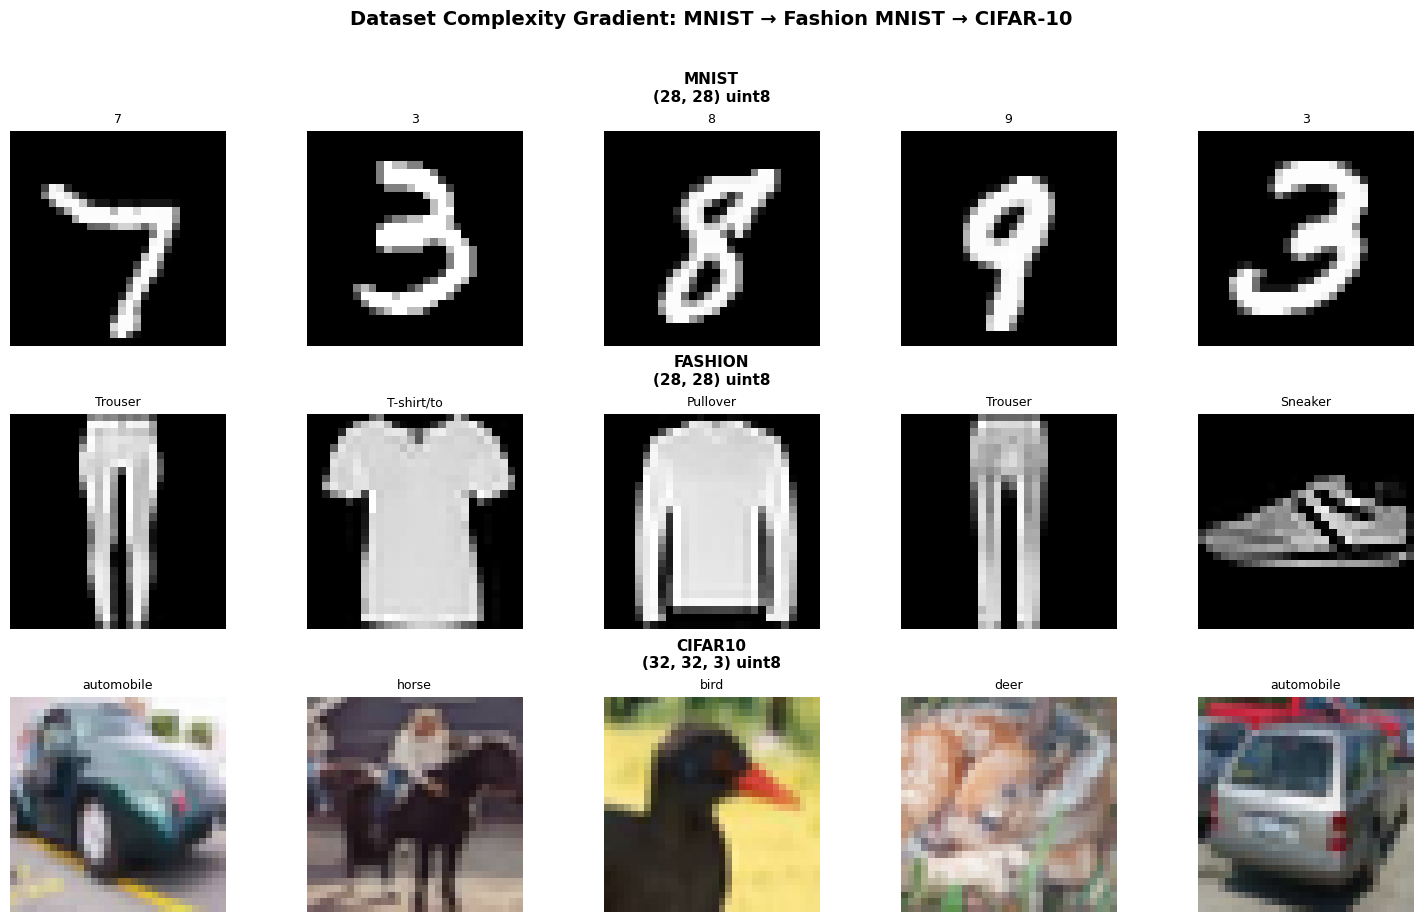

In [5]:
# %% [code]
# -------------------------------------------------------------------
# 📌 DATASETS with multiple mirrors for reliability
# -------------------------------------------------------------------
DATASETS = {
    "mnist": {
        "train_images": [
            "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
            "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        ],
        "train_labels": [
            "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
            "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        ],
        "test_images": [
            "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
            "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        ],
        "test_labels": [
            "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz",
            "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        ],
    },
    "fashion": {
        "train_images": ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"],
        "train_labels": ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"],
        "test_images": ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"],
        "test_labels": ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"],
    },
    "cifar10": {
        "train_batch": ["https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"],
    }
}

# -------------------------------------------------------------------
# 📌 Download with retries and progress bar
# -------------------------------------------------------------------
def download_with_retry(url_list, out_path, retries=3):
    """Robust download with progress bar and retry logic"""
    for url in url_list:
        for attempt in range(retries):
            try:
                print(f"   Downloading: {os.path.basename(out_path)} (attempt {attempt+1}/{retries})")
                
                with urllib.request.urlopen(url) as response:
                    total = int(response.headers.get("Content-Length", 0))
                    with open(out_path, "wb") as f, tqdm(
                        total=total, unit="B", unit_scale=True, 
                        desc=os.path.basename(out_path)[:30]
                    ) as bar:
                        while True:
                            chunk = response.read(8192)
                            if not chunk:
                                break
                            f.write(chunk)
                            bar.update(len(chunk))
                
                print("     ✓ Download successful")
                return True
                
            except Exception as e:
                print(f"     ⚠ Error: {e}\n     Retrying...")
    
    print(f"     ❌ Failed to download: {url_list}")
    return False

# -------------------------------------------------------------------
# 📌 Parse CIFAR-10 files
# -------------------------------------------------------------------
def load_cifar10_batch(file_path):
    """Load single CIFAR-10 batch"""
    with open(file_path, 'rb') as f:
        batch = pkl.load(f, encoding='latin1')
        X = batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        y = np.array(batch['labels'])
    return X, y

def load_cifar10(root):
    """Load all CIFAR-10 batches"""
    X_train = []
    y_train = []
    
    # Load training batches
    for i in range(1, 6):
        batch_path = os.path.join(root, f"data_batch_{i}")
        X_batch, y_batch = load_cifar10_batch(batch_path)
        X_train.append(X_batch)
        y_train.append(y_batch)
    
    # Concatenate
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    # Load test batch
    test_path = os.path.join(root, "test_batch")
    X_test, y_test = load_cifar10_batch(test_path)
    
    # CIFAR-10 classes
    cifar10_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    
    return (X_train, y_train), (X_test, y_test), cifar10_classes

# -------------------------------------------------------------------
# 📌 Industrial Data Loader
# -------------------------------------------------------------------
class IndustrialDataLoader:
    """Load datasets directly from URLs with caching"""
    
    def __init__(self, dataset="mnist"):
        assert dataset in DATASETS, f"Unknown dataset. Available: {list(DATASETS.keys())}"
        self.dataset = dataset
        self.root = DATA_DIR / dataset
        self.root.mkdir(parents=True, exist_ok=True)
        
        # Class names for each dataset
        if dataset == "mnist":
            self.classes = [str(i) for i in range(10)]
        elif dataset == "fashion":
            self.classes = [
                "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
            ]
        elif dataset == "cifar10":
            self.classes = [
                'airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck'
            ]

    def load(self):
        """Load dataset with progress indication"""
        print(f"📥 Loading {self.dataset.upper()} from source URLs...")
        
        if self.dataset in ["mnist", "fashion"]:
            return self._load_mnist_style()
        else:  # cifar10
            return self._load_cifar10()
    
    def _load_mnist_style(self):
        """Load MNIST or Fashion MNIST"""
        # Download files
        for file_type, urls in DATASETS[self.dataset].items():
            file_path = self.root / f"{file_type}.gz"
            if not file_path.exists():
                download_with_retry(urls, file_path)
        
        # Parse IDX format
        def load_idx_images(filename):
            with gzip.open(filename, 'rb') as f:
                magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
                images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
            return images
        
        def load_idx_labels(filename):
            with gzip.open(filename, 'rb') as f:
                magic, num = struct.unpack('>II', f.read(8))
                labels = np.frombuffer(f.read(), dtype=np.uint8)
            return labels
        
        # Load data
        X_train = load_idx_images(self.root / "train_images.gz")
        y_train = load_idx_labels(self.root / "train_labels.gz")
        X_test = load_idx_images(self.root / "test_images.gz")
        y_test = load_idx_labels(self.root / "test_labels.gz")
        
        print(f"     ✓ {self.dataset.upper()}: {X_train.shape[0]:,} train, {X_test.shape[0]:,} test")
        return (X_train, y_train), (X_test, y_test), self.classes
    
    def _load_cifar10(self):
        """Load CIFAR-10"""
        # Download and extract
        tar_path = self.root / "cifar-10-python.tar.gz"
        extracted_path = self.root / "cifar-10-batches-py"
        
        if not tar_path.exists():
            download_with_retry(DATASETS["cifar10"]["train_batch"], tar_path)
        
        if not extracted_path.exists():
            print("     Extracting CIFAR-10...")
            with tarfile.open(tar_path, 'r:gz') as tar:
                tar.extractall(path=self.root)
        
        # Load data
        (X_train, y_train), (X_test, y_test), _ = load_cifar10(extracted_path)
        
        print(f"     ✓ CIFAR-10: {X_train.shape[0]:,} train, {X_test.shape[0]:,} test")
        return (X_train, y_train), (X_test, y_test), self.classes

# -------------------------------------------------------------------
# 📌 Load and visualize all datasets
# -------------------------------------------------------------------
print("\n📊 LOADING ALL 3 DATASETS FROM SOURCE URLs")
print("=" * 60)

all_datasets = {}
for dataset_name in ["mnist", "fashion", "cifar10"]:
    loader = IndustrialDataLoader(dataset=dataset_name)
    train_data, test_data, classes = loader.load()
    all_datasets[dataset_name] = {
        'train': train_data,
        'test': test_data,
        'classes': classes
    }

# Visualize dataset complexity
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for row_idx, (dataset_name, data_info) in enumerate(all_datasets.items()):
    X_train, y_train = data_info['train']
    classes = data_info['classes']
    
    # Show 5 random samples per dataset
    indices = np.random.choice(len(X_train), 5, replace=False)
    
    for col_idx, idx in enumerate(indices):
        ax = axes[row_idx, col_idx]
        img = X_train[idx]
        
        if dataset_name == "cifar10":
            ax.imshow(img.astype(np.uint8))
        else:
            ax.imshow(img, cmap='gray')
        
        label = y_train[idx]
        ax.set_title(f"{classes[label][:10]}", fontsize=9)
        ax.axis('off')
    
    # Dataset title
    axes[row_idx, 2].text(0.5, 1.2, f"{dataset_name.upper()}\n{X_train.shape[1:]} {X_train.dtype}", 
                          ha='center', va='center', transform=axes[row_idx, 2].transAxes,
                          fontsize=11, fontweight='bold')

plt.suptitle('Dataset Complexity Gradient: MNIST → Fashion MNIST → CIFAR-10', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(VIZ_DIR / "dataset_complexity.png", dpi=150, bbox_inches='tight')
plt.show()

## 🔧 PART 2: Modular Preprocessing Pipeline

In [6]:
# %% [code]
class DataPreprocessor:
    """Modular preprocessing with configurable transformations"""
    
    def __init__(self, flatten=True, normalize=True, rgb_to_grayscale=False):
        self.flatten = flatten
        self.normalize = normalize
        self.rgb_to_grayscale = rgb_to_grayscale
        
    def transform(self, X, y=None):
        """Apply preprocessing pipeline"""
        X = X.copy().astype(np.float32)
        
        # 1. Convert RGB to grayscale if needed (for DNN comparison)
        if self.rgb_to_grayscale and X.ndim == 4 and X.shape[-1] == 3:
            X = np.mean(X, axis=-1, keepdims=True)
            
        # 2. Normalize to [0, 1]
        if self.normalize:
            X = X / 255.0
            
        # 3. Flatten for DNN
        if self.flatten and X.ndim > 2:
            original_shape = X.shape
            X = X.reshape(X.shape[0], -1)
            
        # 4. One-hot encode labels if provided
        if y is not None:
            y = y.astype(int)
            n_classes = len(np.unique(y))
            y_onehot = np.zeros((len(y), n_classes))
            y_onehot[np.arange(len(y)), y] = 1
            return X, y_onehot
        
        return X
    
    def prepare_dataset(self, X_train, y_train, X_test, y_test, val_size=0.1):
        """Complete dataset preparation"""
        # Transform
        X_train_proc, y_train_proc = self.transform(X_train, y_train)
        X_test_proc, y_test_proc = self.transform(X_test, y_test)
        
        # Create validation split
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train_proc, y_train_proc, 
            test_size=val_size, 
            random_state=42,
            stratify=y_train
        )
        
        print(f"   Prepared: {X_train.shape} → {X_train_final.shape} (train)")
        print(f"             {X_test.shape} → {X_test_proc.shape} (test)")
        print(f"             {X_val.shape} (validation)")
        
        return {
            'X_train': X_train_final, 'y_train': y_train_final,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test_proc, 'y_test': y_test_proc
        }

# Prepare all datasets
print("\n🔧 PREPROCESSING ALL DATASETS")
print("=" * 60)

prepared_data = {}
for dataset_name, data_info in all_datasets.items():
    print(f"\nProcessing {dataset_name.upper()}:")
    
    X_train, y_train = data_info['train']
    X_test, y_test = data_info['test']
    
    # Special preprocessing for CIFAR-10
    if dataset_name == "cifar10":
        preprocessor = DataPreprocessor(flatten=True, rgb_to_grayscale=True)
    else:
        preprocessor = DataPreprocessor(flatten=True)
    
    data_dict = preprocessor.prepare_dataset(X_train, y_train, X_test, y_test)
    prepared_data[dataset_name] = {
        'data': data_dict,
        'classes': data_info['classes'],
        'preprocessor': preprocessor,
        'original_shape': X_train.shape[1:]
    }

print("\n✅ All datasets preprocessed and ready for training")


🔧 PREPROCESSING ALL DATASETS

Processing MNIST:
   Prepared: (60000, 28, 28) → (54000, 784) (train)
             (10000, 28, 28) → (10000, 784) (test)
             (6000, 784) (validation)

Processing FASHION:
   Prepared: (60000, 28, 28) → (54000, 784) (train)
             (10000, 28, 28) → (10000, 784) (test)
             (6000, 784) (validation)

Processing CIFAR10:
   Prepared: (50000, 32, 32, 3) → (45000, 1024) (train)
             (10000, 32, 32, 3) → (10000, 1024) (test)
             (5000, 1024) (validation)

✅ All datasets preprocessed and ready for training


## 🏗️ PART 3: Neural Network Components (First Principles)

In [7]:
# %% [code]
import pickle
import time
from tqdm import tqdm

class NeuralMath:
    """Pure mathematical operations - no state"""
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x):
        return (x > 0).astype(np.float32)
    
    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    @staticmethod
    def cross_entropy(y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    @staticmethod
    def cross_entropy_gradient(y_pred, y_true):
        return y_pred - y_true
    
    @staticmethod
    def initialize_weights(shape, activation='relu'):
        """Smart initialization"""
        if activation == 'relu':
            # He initialization
            std = np.sqrt(2.0 / shape[0])
        else:
            # Xavier initialization
            std = np.sqrt(2.0 / (shape[0] + shape[1]))
        return np.random.randn(*shape) * std

class DenseLayer:
    """Single neural network layer"""
    
    def __init__(self, input_size, output_size, activation='relu', l2_lambda=0.0001):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.l2_lambda = l2_lambda
        
        # Initialize parameters
        self.weights = NeuralMath.initialize_weights((input_size, output_size), activation)
        self.biases = np.zeros((1, output_size))
        
        # Cache for backprop
        self.input_cache = None
        self.output_cache = None
        
    def forward(self, X):
        """Forward pass"""
        self.input_cache = X
        Z = X @ self.weights + self.biases
        
        if self.activation == 'relu':
            A = NeuralMath.relu(Z)
        elif self.activation == 'softmax':
            A = NeuralMath.softmax(Z)
        else:
            A = Z
        
        self.output_cache = A
        return A
    
    def backward(self, dL_dA, learning_rate):
        """Backward pass"""
        batch_size = self.input_cache.shape[0]
        
        if self.activation == 'relu':
            dA_dZ = NeuralMath.relu_derivative(self.output_cache)
            dL_dZ = dL_dA * dA_dZ
        elif self.activation == 'softmax':
            dL_dZ = dL_dA
        else:
            dL_dZ = dL_dA
        
        # Compute gradients
        dL_dW = (self.input_cache.T @ dL_dZ) / batch_size
        dL_db = np.sum(dL_dZ, axis=0, keepdims=True) / batch_size
        
        # Add L2 regularization
        if self.l2_lambda > 0:
            dL_dW += self.l2_lambda * self.weights / batch_size
        
        # Update parameters
        self.weights -= learning_rate * dL_dW
        self.biases -= learning_rate * dL_db
        
        # Gradient for previous layer
        dL_dinput = dL_dZ @ self.weights.T
        return dL_dinput
    
    @property
    def num_params(self):
        return self.weights.size + self.biases.size

class DNN:
    """Deep Neural Network with training visualization"""
    
    def __init__(self, layer_sizes, activations, learning_rate=0.001, 
                 l2_lambda=0.0001, name="DNN"):
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.name = name
        
        # Build layers
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            layer = DenseLayer(
                input_size=layer_sizes[i],
                output_size=layer_sizes[i + 1],
                activation=activations[i],
                l2_lambda=l2_lambda
            )
            self.layers.append(layer)
        
        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'epoch_times': [],
            'learning_rates': []
        }
        
        print(f"🧠 Built {name}: {layer_sizes}")
        print(f"   Parameters: {self.num_params:,}")
    
    @property
    def num_params(self):
        return sum(layer.num_params for layer in self.layers)
    
    def forward(self, X, training=True):
        """Forward pass through all layers"""
        activations = X
        for layer in self.layers:
            activations = layer.forward(activations)
        return activations
    
    def compute_loss(self, y_pred, y_true):
        """Compute total loss"""
        loss = NeuralMath.cross_entropy(y_pred, y_true)
        
        # Add L2 regularization
        if self.l2_lambda > 0:
            reg_loss = 0
            for layer in self.layers:
                reg_loss += np.sum(layer.weights ** 2)
            loss += (self.l2_lambda / (2 * y_true.shape[0])) * reg_loss
        
        return loss
    
    def compute_accuracy(self, y_pred, y_true):
        """Compute accuracy"""
        pred_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(pred_labels == true_labels)
    
    def train_epoch(self, X_batch, y_batch):
        """Single training step"""
        # Forward pass
        y_pred = self.forward(X_batch)
        
        # Compute gradient
        loss_grad = NeuralMath.cross_entropy_gradient(y_pred, y_batch)
        
        # Backward pass
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad, self.learning_rate)
        
        # Compute metrics
        loss = self.compute_loss(y_pred, y_batch)
        accuracy = self.compute_accuracy(y_pred, y_batch)
        
        return loss, accuracy
    
    def train(self, X_train, y_train, X_val=None, y_val=None, 
              epochs=20, batch_size=64, verbose=True):
        """Training loop with progress bars"""
        n_samples = X_train.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))
        
        print(f"🚀 Training {self.name} for {epochs} epochs")
        print(f"   Samples: {n_samples:,}, Batch size: {batch_size}, Batches/epoch: {n_batches}")
        print("-" * 70)
        
        for epoch in range(epochs):
            epoch_start = time.time()
            epoch_loss, epoch_acc = 0, 0
            
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Mini-batch training with progress bar
            with tqdm(total=n_batches, desc=f"Epoch {epoch+1}/{epochs}", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                     leave=False) as pbar:
                for batch in range(n_batches):
                    start = batch * batch_size
                    end = min(start + batch_size, n_samples)
                    
                    X_batch = X_shuffled[start:end]
                    y_batch = y_shuffled[start:end]
                    
                    batch_loss, batch_acc = self.train_epoch(X_batch, y_batch)
                    epoch_loss += batch_loss
                    epoch_acc += batch_acc
                    
                    # Update progress bar
                    pbar.set_postfix({
                        'loss': f'{batch_loss:.4f}',
                        'acc': f'{batch_acc:.2%}'
                    })
                    pbar.update(1)
            
            # Average over batches
            epoch_loss /= n_batches
            epoch_acc /= n_batches
            
            # Validation
            if X_val is not None and y_val is not None:
                y_val_pred = self.forward(X_val)
                val_loss = self.compute_loss(y_val_pred, y_val)
                val_acc = self.compute_accuracy(y_val_pred, y_val)
            else:
                val_loss, val_acc = None, None
            
            # Record history
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_acc)
            self.history['epoch_times'].append(time.time() - epoch_start)
            self.history['learning_rates'].append(self.learning_rate)
            
            if val_loss is not None:
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
            
            # Progress report
            if verbose:
                if val_loss is not None:
                    print(f"Epoch {epoch+1:3d} | Train: loss={epoch_loss:.4f}, acc={epoch_acc:.2%} | "
                          f"Val: loss={val_loss:.4f}, acc={val_acc:.2%} | Time: {self.history['epoch_times'][-1]:.1f}s")
                else:
                    print(f"Epoch {epoch+1:3d} | Train: loss={epoch_loss:.4f}, acc={epoch_acc:.2%} | "
                          f"Time: {self.history['epoch_times'][-1]:.1f}s")
        
        print("-" * 70)
        avg_time = np.mean(self.history['epoch_times'])
        print(f"✅ Training complete. Avg time/epoch: {avg_time:.2f}s")
    
    def evaluate(self, X, y):
        """Evaluate model"""
        y_pred = self.forward(X)
        loss = self.compute_loss(y_pred, y)
        accuracy = self.compute_accuracy(y_pred, y)
        return loss, accuracy
    
    def predict(self, X):
        """Make predictions"""
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1), y_pred
    
    def save(self, filename):
        """Save model to disk"""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"💾 Saved: {filename}")
    
    @staticmethod
    def load(filename):
        """Load model from disk"""
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"📂 Loaded: {filename}")
        return model

## 📊 PART 4: Training Visualization System

In [8]:
# %% [code]
class TrainingVisualizer:
    """Comprehensive training visualization"""
    
    @staticmethod
    def plot_training_history(history, model_name, dataset_name, save_path=None):
        """Create 2x2 visualization grid"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        epochs = range(1, len(history['train_loss']) + 1)
        
        # 1. Loss curves
        ax = axes[0, 0]
        ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
        if history['val_loss']:
            ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Loss Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Accuracy curves
        ax = axes[0, 1]
        ax.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
        if history['val_acc']:
            ax.plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Training time per epoch
        ax = axes[1, 0]
        ax.plot(epochs, history['epoch_times'], 'purple', marker='o', alpha=0.7)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Time (seconds)')
        ax.set_title('Training Time per Epoch')
        ax.grid(True, alpha=0.3)
        
        # 4. Loss-Accuracy tradeoff
        ax = axes[1, 1]
        scatter = ax.scatter(history['train_loss'], history['train_acc'], 
                           c=epochs, cmap='viridis', s=50, alpha=0.7)
        ax.set_xlabel('Loss')
        ax.set_ylabel('Accuracy')
        ax.set_title('Loss vs Accuracy (Epochs)')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Epoch')
        
        plt.suptitle(f'{model_name} on {dataset_name}', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_all_models_comparison(all_results):
        """Compare all 9 models"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Extract data
        model_names = []
        datasets = []
        test_accuracies = []
        parameters = []
        
        for (model_name, dataset_name), results in all_results.items():
            model_names.append(model_name)
            datasets.append(dataset_name)
            test_accuracies.append(results['test_accuracy'])
            parameters.append(results['parameters'])
        
        # Color by dataset
        dataset_colors = {'mnist': 'blue', 'fashion': 'orange', 'cifar10': 'green'}
        colors = [dataset_colors[d] for d in datasets]
        
        # 1. Test accuracy comparison
        x_pos = np.arange(len(model_names))
        bars = axes[0].bar(x_pos, test_accuracies, color=colors, edgecolor='black')
        axes[0].set_xlabel('Model')
        axes[0].set_ylabel('Test Accuracy')
        axes[0].set_title('Test Accuracy Comparison (9 Models)')
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels([f"{m}\n({d})" for m, d in zip(model_names, datasets)], 
                               rotation=45, ha='right', fontsize=8)
        axes[0].set_ylim([0, 1])
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Add accuracy labels
        for bar, acc in zip(bars, test_accuracies):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{acc:.1%}', ha='center', va='bottom', fontsize=8)
        
        # 2. Parameters vs Accuracy
        scatter = axes[1].scatter(parameters, test_accuracies, s=100, c=colors, 
                                 edgecolor='black', alpha=0.7)
        axes[1].set_xlabel('Number of Parameters')
        axes[1].set_ylabel('Test Accuracy')
        axes[1].set_title('Parameters vs Accuracy Efficiency')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xscale('log')
        
        # Add labels for each point
        for i, (model, dataset, param, acc) in enumerate(zip(model_names, datasets, parameters, test_accuracies)):
            axes[1].annotate(f"{model}\n{dataset}", 
                           (param, acc), 
                           xytext=(5, 5), 
                           textcoords='offset points',
                           fontsize=7,
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # 3. Dataset performance comparison
        ax = axes[2]
        dataset_means = {}
        for dataset in ['mnist', 'fashion', 'cifar10']:
            dataset_accs = [acc for d, acc in zip(datasets, test_accuracies) if d == dataset]
            if dataset_accs:
                dataset_means[dataset] = np.mean(dataset_accs)
        
        bars_ds = ax.bar(range(len(dataset_means)), list(dataset_means.values()), 
                        color=[dataset_colors[d] for d in dataset_means.keys()], 
                        edgecolor='black')
        ax.set_xlabel('Dataset')
        ax.set_ylabel('Average Test Accuracy')
        ax.set_title('Dataset Difficulty Comparison')
        ax.set_xticks(range(len(dataset_means)))
        ax.set_xticklabels([f"{d.upper()}\n({len([x for x in datasets if x == d])} models)" 
                           for d in dataset_means.keys()])
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3, axis='y')
        
        for bar, acc in zip(bars_ds, dataset_means.values()):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.1%}', ha='center', va='bottom', fontsize=9)
        
        plt.suptitle('3×3 Experiment Matrix: 3 Architectures × 3 Datasets', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(VIZ_DIR / 'all_models_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Print summary table
        print("\n📊 SUMMARY TABLE: 3×3 EXPERIMENT MATRIX")
        print("=" * 85)
        print(f"{'Model':<20} {'Dataset':<15} {'Test Acc':<12} {'Params':<15} {'Params/Acc':<15}")
        print("-" * 85)
        
        for (model_name, dataset_name), results in all_results.items():
            params = results['parameters']
            acc = results['test_accuracy']
            efficiency = params / (acc + 1e-8)
            
            print(f"{model_name:<20} {dataset_name:<15} {acc:<12.2%} {params:<15,} {efficiency:,.0f}")
        
        print("-" * 85)

## 🧪 PART 5: 3×3 Experiment Matrix (9 Models)


🔬 RUNNING 3×3 EXPERIMENT MATRIX (9 MODELS)

🏗️  ARCHITECTURE: SIMPLE_DNN
------------------------------------------------------------
🧠 Built simple_dnn_mnist: [784, 64, 10]
   Parameters: 50,890

📊 Training simple_dnn_mnist:
🚀 Training simple_dnn_mnist for 20 epochs
   Samples: 54,000, Batch size: 64, Batches/epoch: 844
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.0776, acc=34.00% | Val: loss=1.8013, acc=58.07% | Time: 11.8s


Epoch   2 | Train: loss=1.5505, acc=67.61% | Val: loss=1.3282, acc=72.93% | Time: 9.8s


Epoch   3 | Train: loss=1.1651, acc=76.19% | Val: loss=1.0361, acc=78.78% | Time: 10.0s


Epoch   4 | Train: loss=0.9390, acc=80.03% | Val: loss=0.8631, acc=82.00% | Time: 10.7s


Epoch   5 | Train: loss=0.8009, acc=82.28% | Val: loss=0.7524, acc=83.33% | Time: 10.4s


Epoch   6 | Train: loss=0.7096, acc=83.70% | Val: loss=0.6766, acc=84.60% | Time: 10.1s


Epoch   7 | Train: loss=0.6456, acc=84.73% | Val: loss=0.6218, acc=85.30% | Time: 9.3s


Epoch   8 | Train: loss=0.5981, acc=85.49% | Val: loss=0.5802, acc=85.87% | Time: 8.7s


Epoch   9 | Train: loss=0.5615, acc=86.14% | Val: loss=0.5477, acc=86.35% | Time: 9.3s


Epoch  10 | Train: loss=0.5323, acc=86.66% | Val: loss=0.5215, acc=86.85% | Time: 10.1s


Epoch  11 | Train: loss=0.5085, acc=87.04% | Val: loss=0.5000, acc=87.17% | Time: 9.6s


Epoch  12 | Train: loss=0.4887, acc=87.37% | Val: loss=0.4818, acc=87.53% | Time: 9.9s


Epoch  13 | Train: loss=0.4719, acc=87.70% | Val: loss=0.4664, acc=87.80% | Time: 9.3s


Epoch  14 | Train: loss=0.4575, acc=87.98% | Val: loss=0.4533, acc=88.17% | Time: 8.6s


Epoch  15 | Train: loss=0.4450, acc=88.25% | Val: loss=0.4417, acc=88.33% | Time: 9.6s


Epoch  16 | Train: loss=0.4339, acc=88.45% | Val: loss=0.4315, acc=88.57% | Time: 9.7s


Epoch  17 | Train: loss=0.4241, acc=88.64% | Val: loss=0.4226, acc=88.80% | Time: 10.5s


Epoch  18 | Train: loss=0.4154, acc=88.84% | Val: loss=0.4146, acc=88.85% | Time: 9.2s


Epoch  19 | Train: loss=0.4075, acc=89.03% | Val: loss=0.4074, acc=88.82% | Time: 9.5s


Epoch  20 | Train: loss=0.4005, acc=89.16% | Val: loss=0.4008, acc=89.00% | Time: 9.9s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 9.81s
   Test Accuracy: 90.02%, Test Loss: 0.3783
💾 Saved: dl_pipeline_lecture3/models/simple_dnn_mnist.pkl


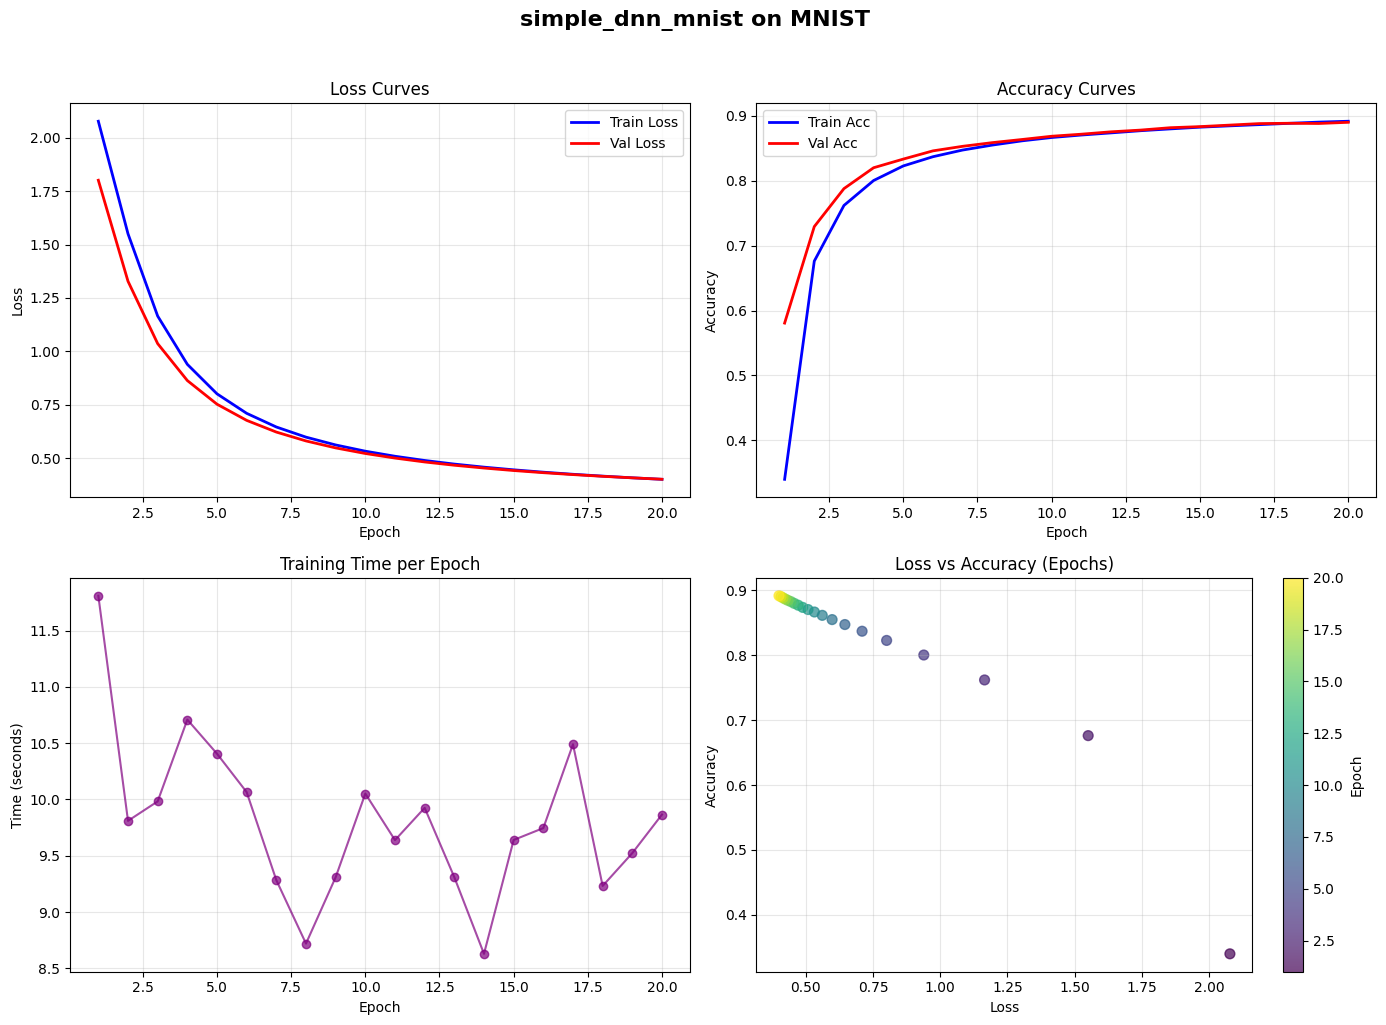

🧠 Built simple_dnn_fashion: [784, 64, 10]
   Parameters: 50,890

📊 Training simple_dnn_fashion:
🚀 Training simple_dnn_fashion for 20 epochs
   Samples: 54,000, Batch size: 64, Batches/epoch: 844
----------------------------------------------------------------------


Epoch   1 | Train: loss=1.8905, acc=41.78% | Val: loss=1.5106, acc=61.37% | Time: 9.4s


Epoch   2 | Train: loss=1.2912, acc=65.59% | Val: loss=1.1270, acc=68.68% | Time: 9.8s


Epoch   3 | Train: loss=1.0317, acc=69.64% | Val: loss=0.9521, acc=71.12% | Time: 9.9s


Epoch   4 | Train: loss=0.9035, acc=71.90% | Val: loss=0.8541, acc=73.78% | Time: 9.2s


Epoch   5 | Train: loss=0.8264, acc=74.02% | Val: loss=0.7906, acc=75.10% | Time: 10.9s


Epoch   6 | Train: loss=0.7736, acc=75.43% | Val: loss=0.7446, acc=76.57% | Time: 8.8s


Epoch   7 | Train: loss=0.7345, acc=76.57% | Val: loss=0.7114, acc=77.68% | Time: 9.8s


Epoch   8 | Train: loss=0.7041, acc=77.53% | Val: loss=0.6827, acc=78.42% | Time: 10.2s


Epoch   9 | Train: loss=0.6797, acc=78.26% | Val: loss=0.6596, acc=78.93% | Time: 9.4s


Epoch  10 | Train: loss=0.6595, acc=78.80% | Val: loss=0.6400, acc=79.50% | Time: 9.5s


Epoch  11 | Train: loss=0.6423, acc=79.30% | Val: loss=0.6247, acc=79.75% | Time: 9.8s


Epoch  12 | Train: loss=0.6276, acc=79.74% | Val: loss=0.6099, acc=80.08% | Time: 9.9s


Epoch  13 | Train: loss=0.6148, acc=80.11% | Val: loss=0.5976, acc=80.45% | Time: 10.1s


Epoch  14 | Train: loss=0.6035, acc=80.37% | Val: loss=0.5868, acc=80.95% | Time: 10.5s


Epoch  15 | Train: loss=0.5934, acc=80.62% | Val: loss=0.5763, acc=81.17% | Time: 9.2s


Epoch  16 | Train: loss=0.5842, acc=80.87% | Val: loss=0.5673, acc=81.18% | Time: 9.3s


Epoch  17 | Train: loss=0.5760, acc=81.14% | Val: loss=0.5592, acc=81.62% | Time: 9.5s


Epoch  18 | Train: loss=0.5687, acc=81.30% | Val: loss=0.5519, acc=81.98% | Time: 9.4s


Epoch  19 | Train: loss=0.5617, acc=81.43% | Val: loss=0.5447, acc=81.88% | Time: 9.4s


Epoch  20 | Train: loss=0.5555, acc=81.68% | Val: loss=0.5390, acc=82.10% | Time: 9.4s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 9.69s
   Test Accuracy: 80.69%, Test Loss: 0.5739
💾 Saved: dl_pipeline_lecture3/models/simple_dnn_fashion.pkl


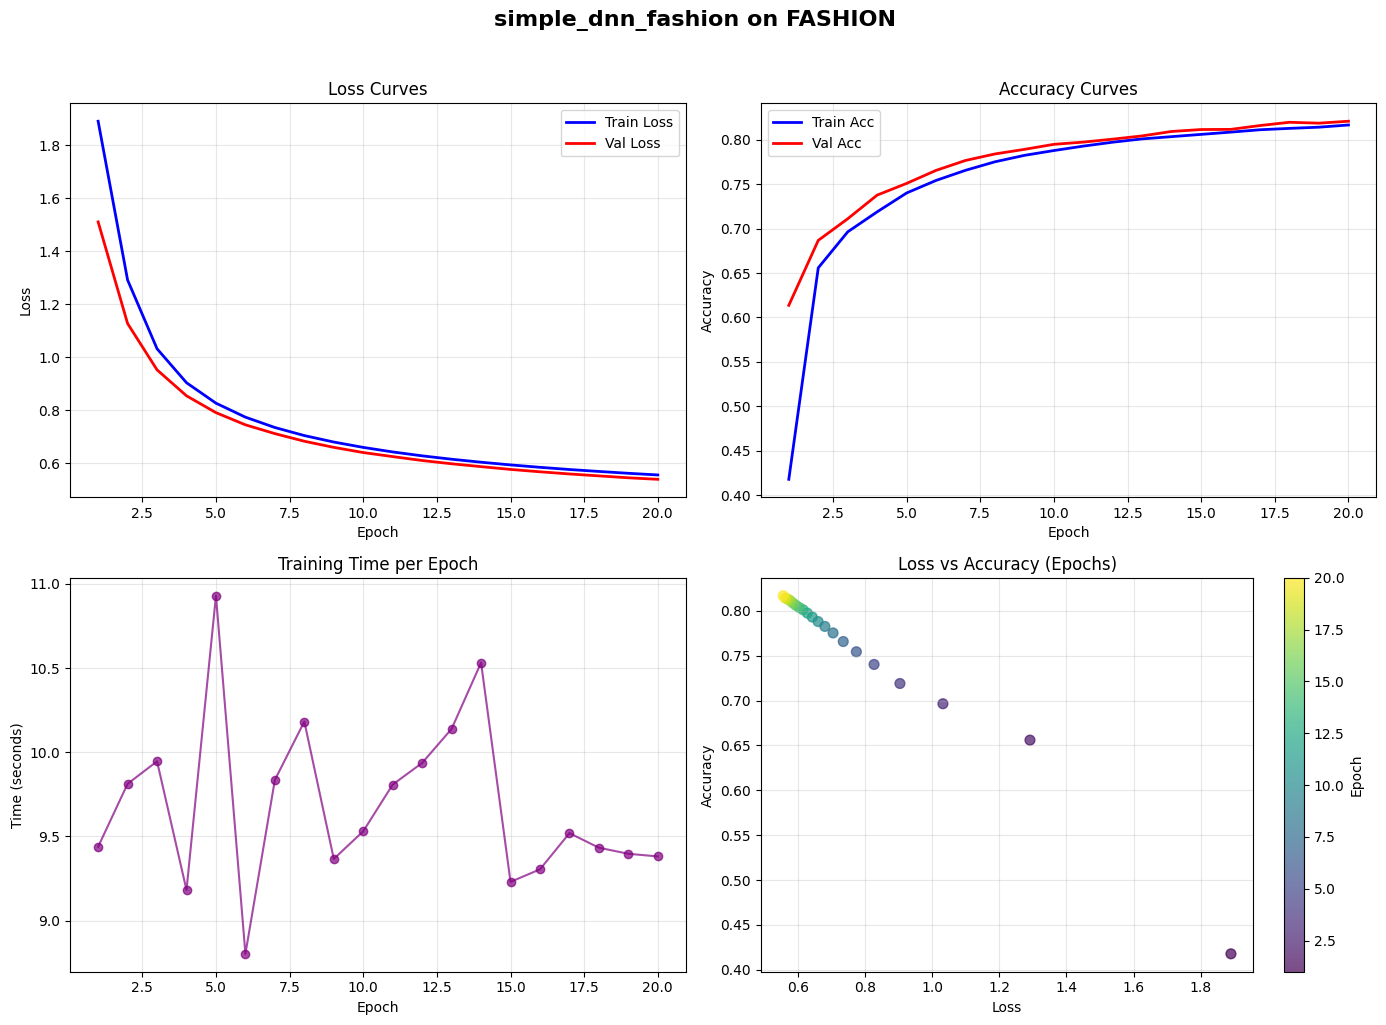

🧠 Built simple_dnn_cifar10: [1024, 64, 10]
   Parameters: 66,250

📊 Training simple_dnn_cifar10:
🚀 Training simple_dnn_cifar10 for 20 epochs
   Samples: 45,000, Batch size: 64, Batches/epoch: 704
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.2975, acc=13.00% | Val: loss=2.2495, acc=17.08% | Time: 9.4s


Epoch   2 | Train: loss=2.2272, acc=17.98% | Val: loss=2.2044, acc=19.38% | Time: 8.6s


Epoch   3 | Train: loss=2.1893, acc=20.28% | Val: loss=2.1712, acc=21.28% | Time: 8.3s


Epoch   4 | Train: loss=2.1622, acc=21.40% | Val: loss=2.1480, acc=22.48% | Time: 8.2s


Epoch   5 | Train: loss=2.1422, acc=22.59% | Val: loss=2.1305, acc=23.12% | Time: 8.4s


Epoch   6 | Train: loss=2.1265, acc=23.23% | Val: loss=2.1173, acc=24.14% | Time: 8.4s


Epoch   7 | Train: loss=2.1131, acc=23.88% | Val: loss=2.1059, acc=24.00% | Time: 8.6s


Epoch   8 | Train: loss=2.1019, acc=24.38% | Val: loss=2.0947, acc=24.60% | Time: 8.0s


Epoch   9 | Train: loss=2.0916, acc=25.02% | Val: loss=2.0860, acc=24.80% | Time: 8.4s


Epoch  10 | Train: loss=2.0831, acc=25.23% | Val: loss=2.0786, acc=25.84% | Time: 8.7s


Epoch  11 | Train: loss=2.0749, acc=25.77% | Val: loss=2.0718, acc=25.94% | Time: 9.0s


Epoch  12 | Train: loss=2.0682, acc=25.98% | Val: loss=2.0665, acc=26.16% | Time: 8.8s


Epoch  13 | Train: loss=2.0622, acc=26.39% | Val: loss=2.0607, acc=26.06% | Time: 9.1s


Epoch  14 | Train: loss=2.0565, acc=26.67% | Val: loss=2.0560, acc=27.16% | Time: 8.6s


Epoch  15 | Train: loss=2.0505, acc=26.98% | Val: loss=2.0515, acc=26.36% | Time: 9.2s


Epoch  16 | Train: loss=2.0463, acc=27.10% | Val: loss=2.0468, acc=27.52% | Time: 8.7s


Epoch  17 | Train: loss=2.0410, acc=27.65% | Val: loss=2.0435, acc=27.22% | Time: 8.7s


Epoch  18 | Train: loss=2.0375, acc=27.65% | Val: loss=2.0391, acc=28.10% | Time: 8.5s


Epoch  19 | Train: loss=2.0328, acc=27.88% | Val: loss=2.0352, acc=28.10% | Time: 9.3s


Epoch  20 | Train: loss=2.0289, acc=28.16% | Val: loss=2.0321, acc=28.18% | Time: 7.9s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 8.64s
   Test Accuracy: 28.48%, Test Loss: 2.0327
💾 Saved: dl_pipeline_lecture3/models/simple_dnn_cifar10.pkl


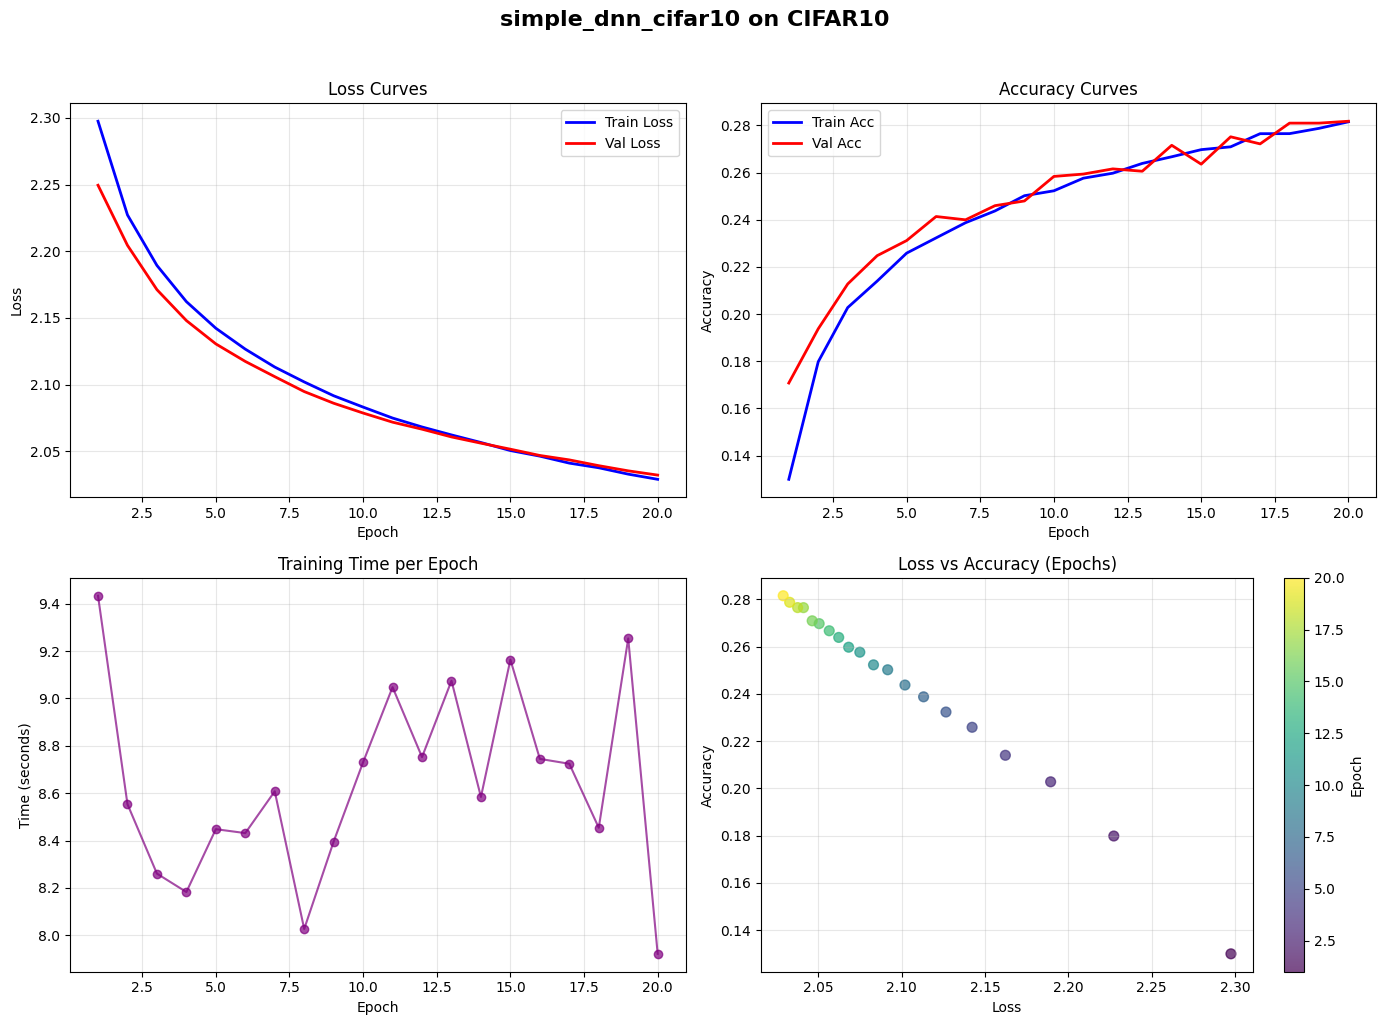


🏗️  ARCHITECTURE: MEDIUM_DNN
------------------------------------------------------------
🧠 Built medium_dnn_mnist: [784, 128, 64, 10]
   Parameters: 109,386

📊 Training medium_dnn_mnist:
🚀 Training medium_dnn_mnist for 25 epochs
   Samples: 54,000, Batch size: 64, Batches/epoch: 844
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.2419, acc=18.24% | Val: loss=2.0748, acc=30.27% | Time: 11.7s


Epoch   2 | Train: loss=1.9275, acc=39.79% | Val: loss=1.7864, acc=48.43% | Time: 11.2s


Epoch   3 | Train: loss=1.6447, acc=56.41% | Val: loss=1.5149, acc=63.12% | Time: 11.5s


Epoch   4 | Train: loss=1.3849, acc=67.87% | Val: loss=1.2736, acc=71.52% | Time: 11.5s


Epoch   5 | Train: loss=1.1642, acc=74.46% | Val: loss=1.0772, acc=76.65% | Time: 12.3s


Epoch   6 | Train: loss=0.9915, acc=78.01% | Val: loss=0.9273, acc=79.62% | Time: 11.8s


Epoch   7 | Train: loss=0.8632, acc=80.20% | Val: loss=0.8164, acc=81.30% | Time: 11.5s


Epoch   8 | Train: loss=0.7687, acc=81.92% | Val: loss=0.7343, acc=82.70% | Time: 10.8s


Epoch   9 | Train: loss=0.6981, acc=83.21% | Val: loss=0.6718, acc=83.95% | Time: 11.6s


Epoch  10 | Train: loss=0.6441, acc=84.22% | Val: loss=0.6236, acc=84.82% | Time: 11.5s


Epoch  11 | Train: loss=0.6016, acc=85.05% | Val: loss=0.5854, acc=85.57% | Time: 11.2s


Epoch  12 | Train: loss=0.5675, acc=85.71% | Val: loss=0.5535, acc=86.07% | Time: 10.9s


Epoch  13 | Train: loss=0.5392, acc=86.23% | Val: loss=0.5276, acc=86.47% | Time: 12.1s


Epoch  14 | Train: loss=0.5157, acc=86.67% | Val: loss=0.5056, acc=86.97% | Time: 11.4s


Epoch  15 | Train: loss=0.4956, acc=87.07% | Val: loss=0.4869, acc=87.33% | Time: 11.3s


Epoch  16 | Train: loss=0.4782, acc=87.43% | Val: loss=0.4708, acc=87.57% | Time: 12.0s


Epoch  17 | Train: loss=0.4631, acc=87.73% | Val: loss=0.4566, acc=87.90% | Time: 12.1s


Epoch  18 | Train: loss=0.4498, acc=88.02% | Val: loss=0.4442, acc=88.12% | Time: 11.2s


Epoch  19 | Train: loss=0.4378, acc=88.23% | Val: loss=0.4334, acc=88.45% | Time: 11.3s


Epoch  20 | Train: loss=0.4272, acc=88.49% | Val: loss=0.4233, acc=88.83% | Time: 11.8s


Epoch  21 | Train: loss=0.4176, acc=88.72% | Val: loss=0.4143, acc=88.92% | Time: 11.3s


Epoch  22 | Train: loss=0.4090, acc=88.97% | Val: loss=0.4062, acc=89.20% | Time: 11.6s


Epoch  23 | Train: loss=0.4008, acc=89.08% | Val: loss=0.3989, acc=89.32% | Time: 11.7s


Epoch  24 | Train: loss=0.3935, acc=89.30% | Val: loss=0.3921, acc=89.55% | Time: 11.3s


Epoch  25 | Train: loss=0.3867, acc=89.44% | Val: loss=0.3859, acc=89.65% | Time: 11.9s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 11.53s
   Test Accuracy: 90.24%, Test Loss: 0.3600
💾 Saved: dl_pipeline_lecture3/models/medium_dnn_mnist.pkl


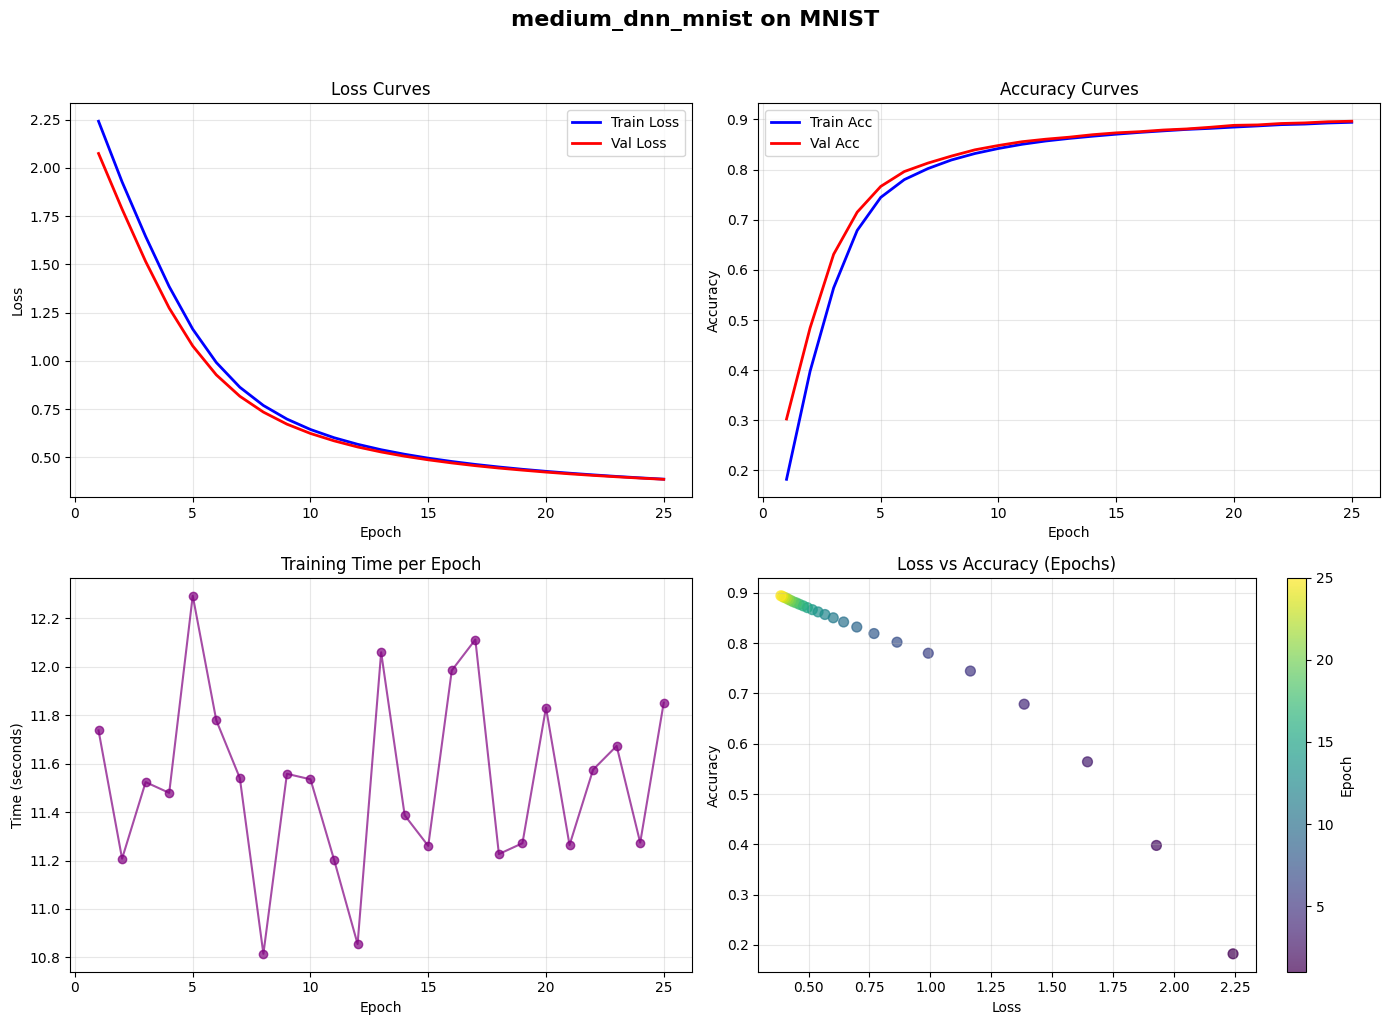

🧠 Built medium_dnn_fashion: [784, 128, 64, 10]
   Parameters: 109,386

📊 Training medium_dnn_fashion:
🚀 Training medium_dnn_fashion for 25 epochs
   Samples: 54,000, Batch size: 64, Batches/epoch: 844
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.0752, acc=31.07% | Val: loss=1.8239, acc=41.48% | Time: 11.4s


Epoch   2 | Train: loss=1.6305, acc=49.48% | Val: loss=1.4687, acc=58.70% | Time: 10.6s


Epoch   3 | Train: loss=1.3361, acc=62.57% | Val: loss=1.2284, acc=63.97% | Time: 10.6s


Epoch   4 | Train: loss=1.1418, acc=65.14% | Val: loss=1.0720, acc=65.65% | Time: 10.9s


Epoch   5 | Train: loss=1.0185, acc=66.40% | Val: loss=0.9725, acc=67.38% | Time: 11.9s


Epoch   6 | Train: loss=0.9385, acc=67.77% | Val: loss=0.9060, acc=68.72% | Time: 11.4s


Epoch   7 | Train: loss=0.8829, acc=69.14% | Val: loss=0.8564, acc=69.88% | Time: 11.9s


Epoch   8 | Train: loss=0.8406, acc=70.42% | Val: loss=0.8178, acc=71.47% | Time: 11.5s


Epoch   9 | Train: loss=0.8068, acc=71.72% | Val: loss=0.7861, acc=72.83% | Time: 11.7s


Epoch  10 | Train: loss=0.7786, acc=72.94% | Val: loss=0.7590, acc=74.07% | Time: 11.0s


Epoch  11 | Train: loss=0.7549, acc=74.04% | Val: loss=0.7361, acc=74.85% | Time: 11.3s


Epoch  12 | Train: loss=0.7339, acc=75.09% | Val: loss=0.7154, acc=75.95% | Time: 13.3s


Epoch  13 | Train: loss=0.7150, acc=75.93% | Val: loss=0.6966, acc=76.80% | Time: 11.5s


Epoch  14 | Train: loss=0.6979, acc=76.72% | Val: loss=0.6795, acc=77.42% | Time: 12.1s


Epoch  15 | Train: loss=0.6825, acc=77.36% | Val: loss=0.6645, acc=77.92% | Time: 13.0s


Epoch  16 | Train: loss=0.6683, acc=77.93% | Val: loss=0.6503, acc=78.38% | Time: 11.1s


Epoch  17 | Train: loss=0.6554, acc=78.48% | Val: loss=0.6385, acc=78.83% | Time: 12.2s


Epoch  18 | Train: loss=0.6435, acc=78.84% | Val: loss=0.6261, acc=79.17% | Time: 11.1s


Epoch  19 | Train: loss=0.6326, acc=79.24% | Val: loss=0.6157, acc=79.45% | Time: 12.1s


Epoch  20 | Train: loss=0.6225, acc=79.51% | Val: loss=0.6057, acc=79.87% | Time: 11.7s


Epoch  21 | Train: loss=0.6130, acc=79.84% | Val: loss=0.5966, acc=79.97% | Time: 12.0s


Epoch  22 | Train: loss=0.6044, acc=80.06% | Val: loss=0.5879, acc=80.22% | Time: 11.7s


Epoch  23 | Train: loss=0.5962, acc=80.30% | Val: loss=0.5794, acc=80.53% | Time: 11.7s


Epoch  24 | Train: loss=0.5886, acc=80.55% | Val: loss=0.5734, acc=80.73% | Time: 11.3s


Epoch  25 | Train: loss=0.5815, acc=80.71% | Val: loss=0.5646, acc=80.93% | Time: 10.6s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 11.58s
   Test Accuracy: 79.54%, Test Loss: 0.5949
💾 Saved: dl_pipeline_lecture3/models/medium_dnn_fashion.pkl


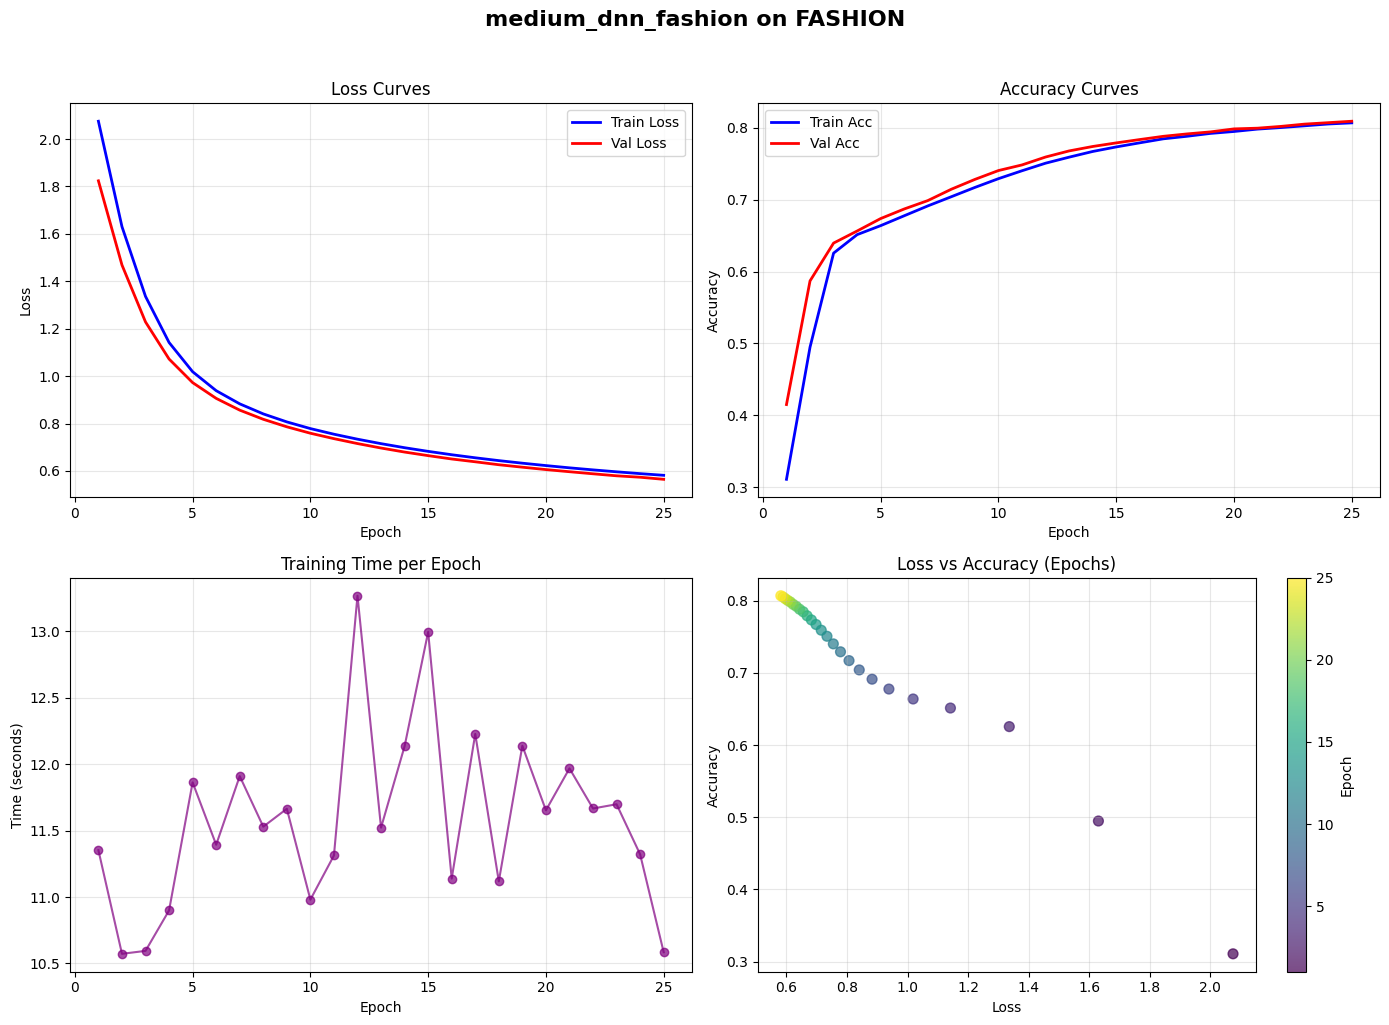

🧠 Built medium_dnn_cifar10: [1024, 128, 64, 10]
   Parameters: 140,106

📊 Training medium_dnn_cifar10:
🚀 Training medium_dnn_cifar10 for 25 epochs
   Samples: 45,000, Batch size: 64, Batches/epoch: 704
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.3072, acc=11.34% | Val: loss=2.2635, acc=15.22% | Time: 10.9s


Epoch   2 | Train: loss=2.2468, acc=16.55% | Val: loss=2.2244, acc=18.26% | Time: 10.3s


Epoch   3 | Train: loss=2.2135, acc=18.62% | Val: loss=2.1955, acc=19.84% | Time: 10.2s


Epoch   4 | Train: loss=2.1885, acc=20.06% | Val: loss=2.1738, acc=21.24% | Time: 10.6s


Epoch   5 | Train: loss=2.1689, acc=21.09% | Val: loss=2.1566, acc=22.08% | Time: 10.6s


Epoch   6 | Train: loss=2.1530, acc=21.75% | Val: loss=2.1420, acc=22.92% | Time: 9.9s


Epoch   7 | Train: loss=2.1396, acc=22.51% | Val: loss=2.1287, acc=23.44% | Time: 11.0s


Epoch   8 | Train: loss=2.1273, acc=23.20% | Val: loss=2.1171, acc=24.32% | Time: 10.7s


Epoch   9 | Train: loss=2.1168, acc=23.77% | Val: loss=2.1062, acc=24.78% | Time: 10.0s


Epoch  10 | Train: loss=2.1066, acc=24.16% | Val: loss=2.0969, acc=24.96% | Time: 10.3s


Epoch  11 | Train: loss=2.0971, acc=24.70% | Val: loss=2.0889, acc=25.08% | Time: 10.3s


Epoch  12 | Train: loss=2.0888, acc=25.02% | Val: loss=2.0804, acc=25.52% | Time: 11.4s


Epoch  13 | Train: loss=2.0809, acc=25.38% | Val: loss=2.0740, acc=26.20% | Time: 10.0s


Epoch  14 | Train: loss=2.0736, acc=25.68% | Val: loss=2.0662, acc=26.78% | Time: 10.6s


Epoch  15 | Train: loss=2.0666, acc=25.96% | Val: loss=2.0595, acc=26.96% | Time: 10.5s


Epoch  16 | Train: loss=2.0602, acc=26.23% | Val: loss=2.0538, acc=27.44% | Time: 10.6s


Epoch  17 | Train: loss=2.0543, acc=26.55% | Val: loss=2.0481, acc=27.28% | Time: 10.7s


Epoch  18 | Train: loss=2.0487, acc=26.87% | Val: loss=2.0460, acc=26.94% | Time: 10.5s


Epoch  19 | Train: loss=2.0438, acc=26.88% | Val: loss=2.0383, acc=28.00% | Time: 10.5s


Epoch  20 | Train: loss=2.0387, acc=27.17% | Val: loss=2.0343, acc=28.06% | Time: 11.2s


Epoch  21 | Train: loss=2.0335, acc=27.52% | Val: loss=2.0295, acc=28.34% | Time: 10.4s


Epoch  22 | Train: loss=2.0291, acc=27.74% | Val: loss=2.0254, acc=28.78% | Time: 10.7s


Epoch  23 | Train: loss=2.0249, acc=27.87% | Val: loss=2.0216, acc=28.70% | Time: 10.5s


Epoch  24 | Train: loss=2.0209, acc=27.94% | Val: loss=2.0183, acc=28.96% | Time: 10.1s


Epoch  25 | Train: loss=2.0170, acc=28.25% | Val: loss=2.0147, acc=28.72% | Time: 11.0s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 10.54s
   Test Accuracy: 28.72%, Test Loss: 2.0195
💾 Saved: dl_pipeline_lecture3/models/medium_dnn_cifar10.pkl


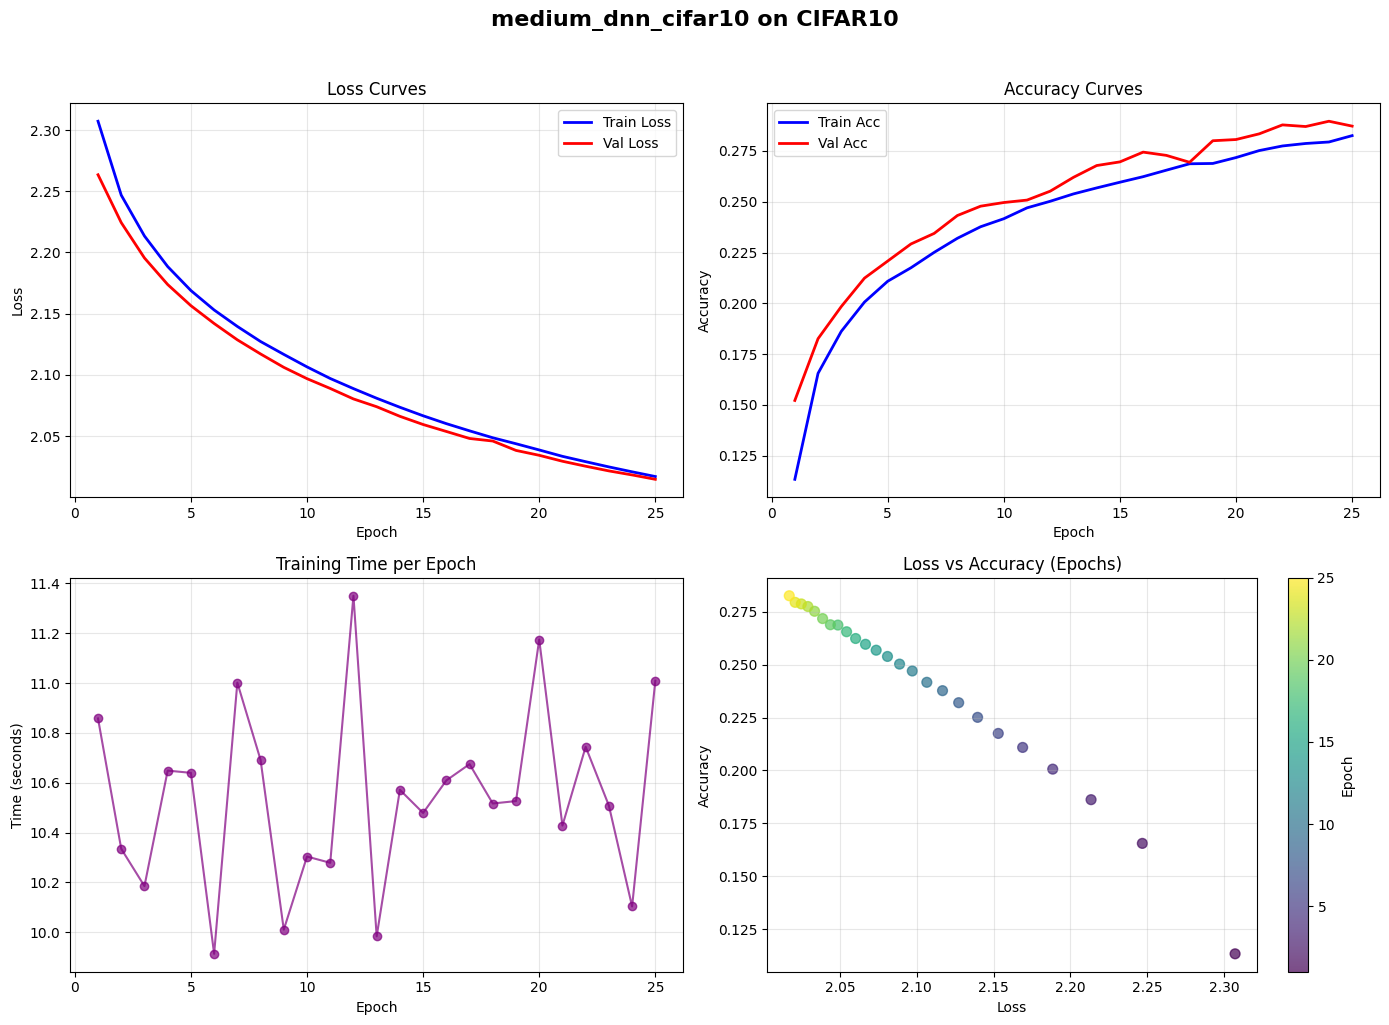


🏗️  ARCHITECTURE: DEEP_DNN
------------------------------------------------------------
🧠 Built deep_dnn_mnist: [784, 256, 128, 64, 10]
   Parameters: 242,762

📊 Training deep_dnn_mnist:
🚀 Training deep_dnn_mnist for 30 epochs
   Samples: 54,000, Batch size: 64, Batches/epoch: 844
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.3233, acc=9.16% | Val: loss=2.2254, acc=14.10% | Time: 17.9s


Epoch   2 | Train: loss=2.1584, acc=23.96% | Val: loss=2.0842, acc=34.25% | Time: 17.5s


Epoch   3 | Train: loss=2.0113, acc=43.97% | Val: loss=1.9304, acc=51.38% | Time: 18.1s


Epoch   4 | Train: loss=1.8431, acc=58.33% | Val: loss=1.7500, acc=62.22% | Time: 17.8s


Epoch   5 | Train: loss=1.6499, acc=66.49% | Val: loss=1.5501, acc=68.27% | Time: 17.7s


Epoch   6 | Train: loss=1.4482, acc=71.56% | Val: loss=1.3521, acc=72.75% | Time: 17.4s


Epoch   7 | Train: loss=1.2576, acc=75.35% | Val: loss=1.1728, acc=75.78% | Time: 17.3s


Epoch   8 | Train: loss=1.0920, acc=77.95% | Val: loss=1.0219, acc=78.33% | Time: 17.8s


Epoch   9 | Train: loss=0.9563, acc=80.03% | Val: loss=0.9005, acc=80.37% | Time: 18.4s


Epoch  10 | Train: loss=0.8489, acc=81.50% | Val: loss=0.8053, acc=81.62% | Time: 17.4s


Epoch  11 | Train: loss=0.7657, acc=82.78% | Val: loss=0.7313, acc=82.92% | Time: 18.4s


Epoch  12 | Train: loss=0.7008, acc=83.72% | Val: loss=0.6733, acc=83.73% | Time: 17.4s


Epoch  13 | Train: loss=0.6497, acc=84.37% | Val: loss=0.6272, acc=84.40% | Time: 17.8s


Epoch  14 | Train: loss=0.6086, acc=85.03% | Val: loss=0.5897, acc=85.07% | Time: 17.3s


Epoch  15 | Train: loss=0.5751, acc=85.61% | Val: loss=0.5589, acc=85.60% | Time: 17.7s


Epoch  16 | Train: loss=0.5472, acc=86.05% | Val: loss=0.5331, acc=86.00% | Time: 18.2s


Epoch  17 | Train: loss=0.5238, acc=86.44% | Val: loss=0.5114, acc=86.47% | Time: 18.4s


Epoch  18 | Train: loss=0.5037, acc=86.81% | Val: loss=0.4926, acc=86.75% | Time: 18.2s


Epoch  19 | Train: loss=0.4864, acc=87.17% | Val: loss=0.4762, acc=87.10% | Time: 18.7s


Epoch  20 | Train: loss=0.4712, acc=87.51% | Val: loss=0.4621, acc=87.40% | Time: 18.3s


Epoch  21 | Train: loss=0.4577, acc=87.72% | Val: loss=0.4493, acc=87.75% | Time: 17.9s


Epoch  22 | Train: loss=0.4458, acc=88.00% | Val: loss=0.4381, acc=87.93% | Time: 18.2s


Epoch  23 | Train: loss=0.4352, acc=88.20% | Val: loss=0.4279, acc=88.00% | Time: 17.9s


Epoch  24 | Train: loss=0.4255, acc=88.33% | Val: loss=0.4187, acc=88.30% | Time: 18.4s


Epoch  25 | Train: loss=0.4167, acc=88.53% | Val: loss=0.4106, acc=88.47% | Time: 18.6s


Epoch  26 | Train: loss=0.4086, acc=88.69% | Val: loss=0.4027, acc=88.65% | Time: 18.8s


Epoch  27 | Train: loss=0.4012, acc=88.93% | Val: loss=0.3957, acc=88.75% | Time: 18.4s


Epoch  28 | Train: loss=0.3943, acc=89.09% | Val: loss=0.3892, acc=88.93% | Time: 18.5s


Epoch  29 | Train: loss=0.3881, acc=89.24% | Val: loss=0.3833, acc=89.13% | Time: 18.9s


Epoch  30 | Train: loss=0.3822, acc=89.41% | Val: loss=0.3777, acc=89.32% | Time: 18.5s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 18.06s
   Test Accuracy: 89.90%, Test Loss: 0.3583
💾 Saved: dl_pipeline_lecture3/models/deep_dnn_mnist.pkl


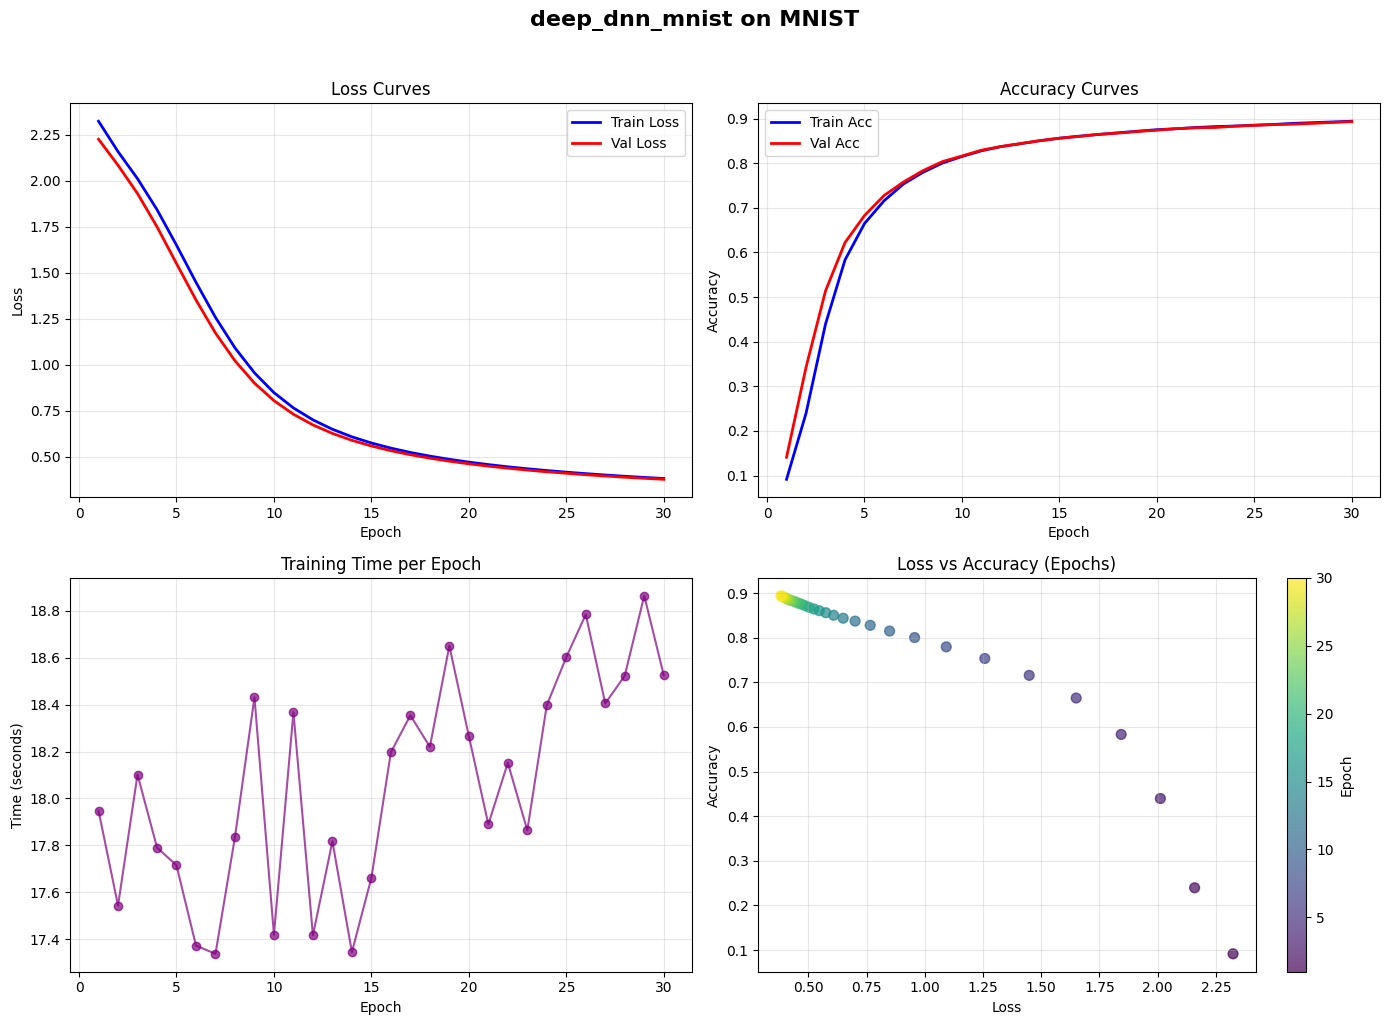

🧠 Built deep_dnn_fashion: [784, 256, 128, 64, 10]
   Parameters: 242,762

📊 Training deep_dnn_fashion:
🚀 Training deep_dnn_fashion for 30 epochs
   Samples: 54,000, Batch size: 64, Batches/epoch: 844
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.0226, acc=31.55% | Val: loss=1.7515, acc=49.30% | Time: 18.7s


Epoch   2 | Train: loss=1.5907, acc=55.95% | Val: loss=1.4408, acc=60.85% | Time: 18.8s


Epoch   3 | Train: loss=1.3271, acc=62.37% | Val: loss=1.2226, acc=63.95% | Time: 18.6s


Epoch   4 | Train: loss=1.1485, acc=65.11% | Val: loss=1.0783, acc=66.53% | Time: 18.6s


Epoch   5 | Train: loss=1.0303, acc=67.50% | Val: loss=0.9809, acc=68.00% | Time: 18.4s


Epoch   6 | Train: loss=0.9489, acc=69.38% | Val: loss=0.9111, acc=70.48% | Time: 18.7s


Epoch   7 | Train: loss=0.8890, acc=71.15% | Val: loss=0.8579, acc=71.80% | Time: 18.7s


Epoch   8 | Train: loss=0.8426, acc=72.60% | Val: loss=0.8171, acc=73.07% | Time: 17.9s


Epoch   9 | Train: loss=0.8056, acc=73.84% | Val: loss=0.7821, acc=74.25% | Time: 18.1s


Epoch  10 | Train: loss=0.7752, acc=74.88% | Val: loss=0.7538, acc=75.40% | Time: 17.5s


Epoch  11 | Train: loss=0.7496, acc=75.79% | Val: loss=0.7294, acc=75.98% | Time: 17.9s


Epoch  12 | Train: loss=0.7277, acc=76.51% | Val: loss=0.7084, acc=76.92% | Time: 18.9s


Epoch  13 | Train: loss=0.7085, acc=77.22% | Val: loss=0.6902, acc=77.02% | Time: 19.1s


Epoch  14 | Train: loss=0.6918, acc=77.67% | Val: loss=0.6738, acc=78.00% | Time: 18.0s


Epoch  15 | Train: loss=0.6768, acc=78.16% | Val: loss=0.6593, acc=78.52% | Time: 18.0s


Epoch  16 | Train: loss=0.6634, acc=78.62% | Val: loss=0.6468, acc=78.63% | Time: 18.4s


Epoch  17 | Train: loss=0.6513, acc=78.90% | Val: loss=0.6346, acc=79.08% | Time: 17.7s


Epoch  18 | Train: loss=0.6401, acc=79.31% | Val: loss=0.6239, acc=79.58% | Time: 18.5s


Epoch  19 | Train: loss=0.6299, acc=79.63% | Val: loss=0.6138, acc=79.97% | Time: 18.0s


Epoch  20 | Train: loss=0.6206, acc=79.81% | Val: loss=0.6036, acc=79.73% | Time: 19.5s


Epoch  21 | Train: loss=0.6121, acc=80.03% | Val: loss=0.5961, acc=80.23% | Time: 18.3s


Epoch  22 | Train: loss=0.6041, acc=80.27% | Val: loss=0.5876, acc=80.40% | Time: 18.3s


Epoch  23 | Train: loss=0.5968, acc=80.41% | Val: loss=0.5805, acc=80.62% | Time: 18.1s


Epoch  24 | Train: loss=0.5899, acc=80.64% | Val: loss=0.5741, acc=80.87% | Time: 18.3s


Epoch  25 | Train: loss=0.5834, acc=80.78% | Val: loss=0.5672, acc=80.93% | Time: 18.8s


Epoch  26 | Train: loss=0.5774, acc=80.95% | Val: loss=0.5614, acc=81.05% | Time: 17.6s


Epoch  27 | Train: loss=0.5717, acc=81.06% | Val: loss=0.5557, acc=81.37% | Time: 18.0s


Epoch  28 | Train: loss=0.5664, acc=81.20% | Val: loss=0.5515, acc=81.35% | Time: 17.9s


Epoch  29 | Train: loss=0.5615, acc=81.32% | Val: loss=0.5453, acc=81.30% | Time: 17.6s


Epoch  30 | Train: loss=0.5567, acc=81.46% | Val: loss=0.5408, acc=81.67% | Time: 18.2s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 18.31s
   Test Accuracy: 80.59%, Test Loss: 0.5692
💾 Saved: dl_pipeline_lecture3/models/deep_dnn_fashion.pkl


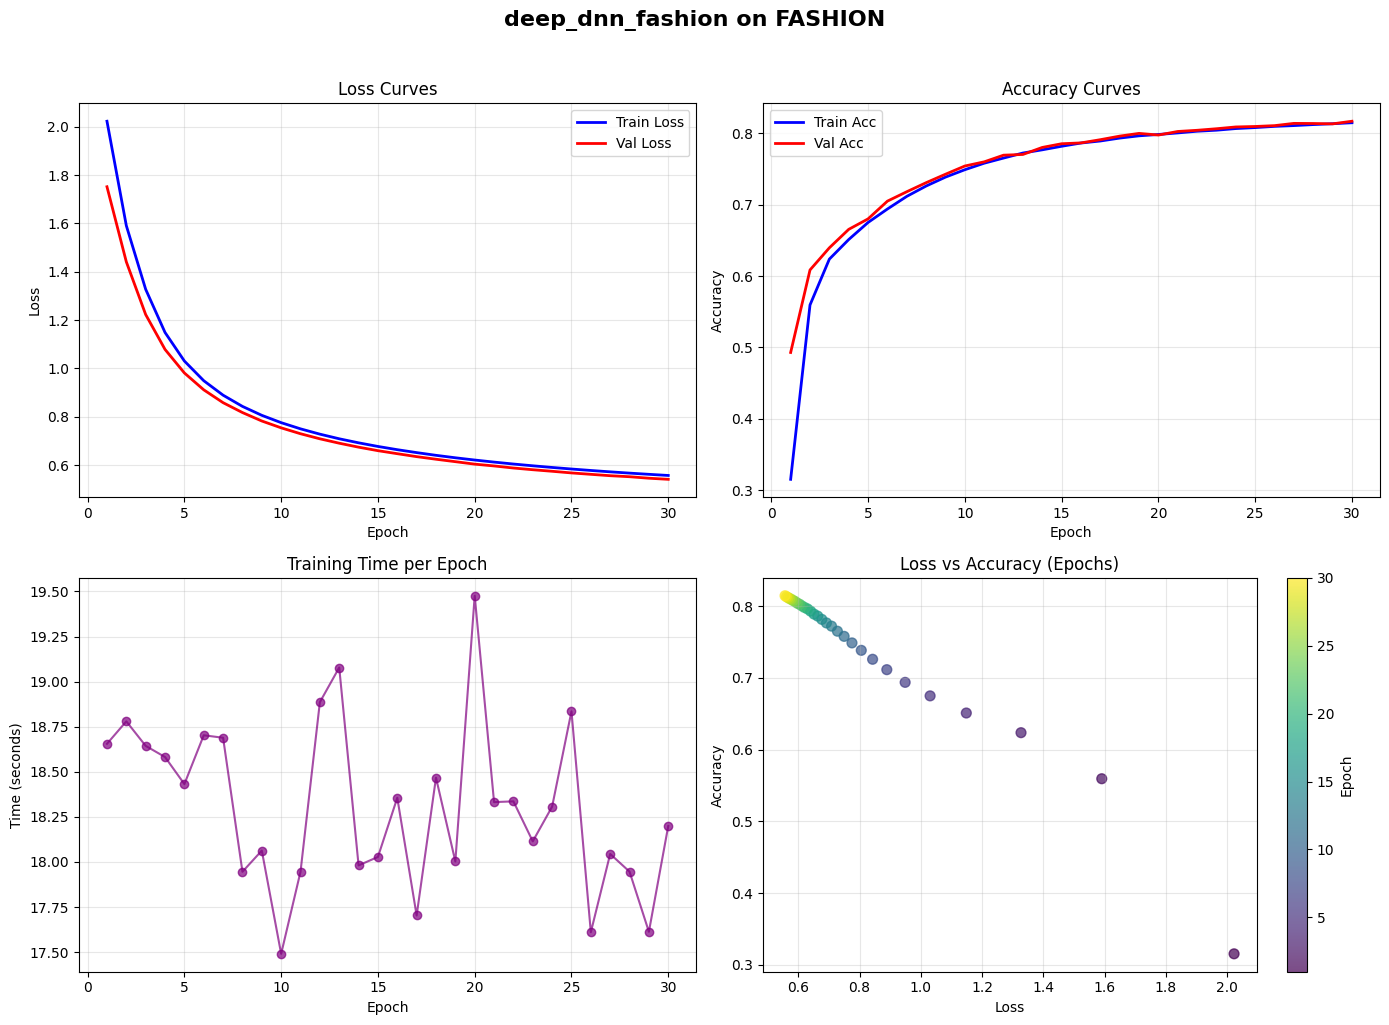

🧠 Built deep_dnn_cifar10: [1024, 256, 128, 64, 10]
   Parameters: 304,202

📊 Training deep_dnn_cifar10:
🚀 Training deep_dnn_cifar10 for 30 epochs
   Samples: 45,000, Batch size: 64, Batches/epoch: 704
----------------------------------------------------------------------


Epoch   1 | Train: loss=2.3197, acc=14.20% | Val: loss=2.2590, acc=17.54% | Time: 16.8s


Epoch   2 | Train: loss=2.2499, acc=18.89% | Val: loss=2.2200, acc=20.22% | Time: 16.6s


Epoch   3 | Train: loss=2.2158, acc=20.16% | Val: loss=2.1906, acc=21.16% | Time: 16.1s


Epoch   4 | Train: loss=2.1897, acc=21.06% | Val: loss=2.1677, acc=21.98% | Time: 18.0s


Epoch   5 | Train: loss=2.1697, acc=21.44% | Val: loss=2.1495, acc=22.80% | Time: 29.9s


Epoch   6 | Train: loss=2.1536, acc=22.12% | Val: loss=2.1351, acc=22.30% | Time: 28.1s


Epoch   7 | Train: loss=2.1402, acc=22.46% | Val: loss=2.1234, acc=23.10% | Time: 32.3s


Epoch   8 | Train: loss=2.1292, acc=22.81% | Val: loss=2.1135, acc=23.54% | Time: 32.2s


Epoch   9 | Train: loss=2.1194, acc=23.18% | Val: loss=2.1047, acc=24.42% | Time: 25.8s


Epoch  10 | Train: loss=2.1101, acc=23.73% | Val: loss=2.0965, acc=24.64% | Time: 20.0s


Epoch  11 | Train: loss=2.1018, acc=24.20% | Val: loss=2.0892, acc=24.94% | Time: 20.3s


Epoch  12 | Train: loss=2.0940, acc=24.49% | Val: loss=2.0825, acc=25.24% | Time: 19.6s


Epoch  13 | Train: loss=2.0873, acc=25.05% | Val: loss=2.0760, acc=26.00% | Time: 19.3s


Epoch  14 | Train: loss=2.0805, acc=25.31% | Val: loss=2.0702, acc=26.06% | Time: 17.3s


Epoch  15 | Train: loss=2.0744, acc=25.52% | Val: loss=2.0642, acc=26.38% | Time: 17.8s


Epoch  16 | Train: loss=2.0679, acc=25.93% | Val: loss=2.0589, acc=26.64% | Time: 18.1s


Epoch  17 | Train: loss=2.0626, acc=26.25% | Val: loss=2.0539, acc=27.04% | Time: 18.0s


Epoch  18 | Train: loss=2.0570, acc=26.53% | Val: loss=2.0488, acc=27.58% | Time: 18.6s


Epoch  19 | Train: loss=2.0524, acc=26.72% | Val: loss=2.0446, acc=26.92% | Time: 19.5s


Epoch  20 | Train: loss=2.0467, acc=27.03% | Val: loss=2.0403, acc=27.44% | Time: 17.2s


Epoch  21 | Train: loss=2.0423, acc=27.25% | Val: loss=2.0355, acc=27.74% | Time: 17.2s


Epoch  22 | Train: loss=2.0379, acc=27.48% | Val: loss=2.0317, acc=28.12% | Time: 17.0s


Epoch  23 | Train: loss=2.0335, acc=27.66% | Val: loss=2.0278, acc=28.34% | Time: 20.6s


Epoch  24 | Train: loss=2.0297, acc=27.78% | Val: loss=2.0246, acc=28.00% | Time: 18.4s


Epoch  25 | Train: loss=2.0257, acc=28.04% | Val: loss=2.0200, acc=28.68% | Time: 17.2s


Epoch  26 | Train: loss=2.0214, acc=28.22% | Val: loss=2.0169, acc=29.20% | Time: 18.4s


Epoch  27 | Train: loss=2.0176, acc=28.36% | Val: loss=2.0133, acc=28.38% | Time: 17.7s


Epoch  28 | Train: loss=2.0137, acc=28.58% | Val: loss=2.0101, acc=29.08% | Time: 16.4s


Epoch  29 | Train: loss=2.0106, acc=28.64% | Val: loss=2.0065, acc=29.10% | Time: 15.6s


Epoch  30 | Train: loss=2.0075, acc=28.76% | Val: loss=2.0033, acc=29.20% | Time: 16.4s
----------------------------------------------------------------------
✅ Training complete. Avg time/epoch: 19.88s
   Test Accuracy: 28.82%, Test Loss: 2.0077
💾 Saved: dl_pipeline_lecture3/models/deep_dnn_cifar10.pkl


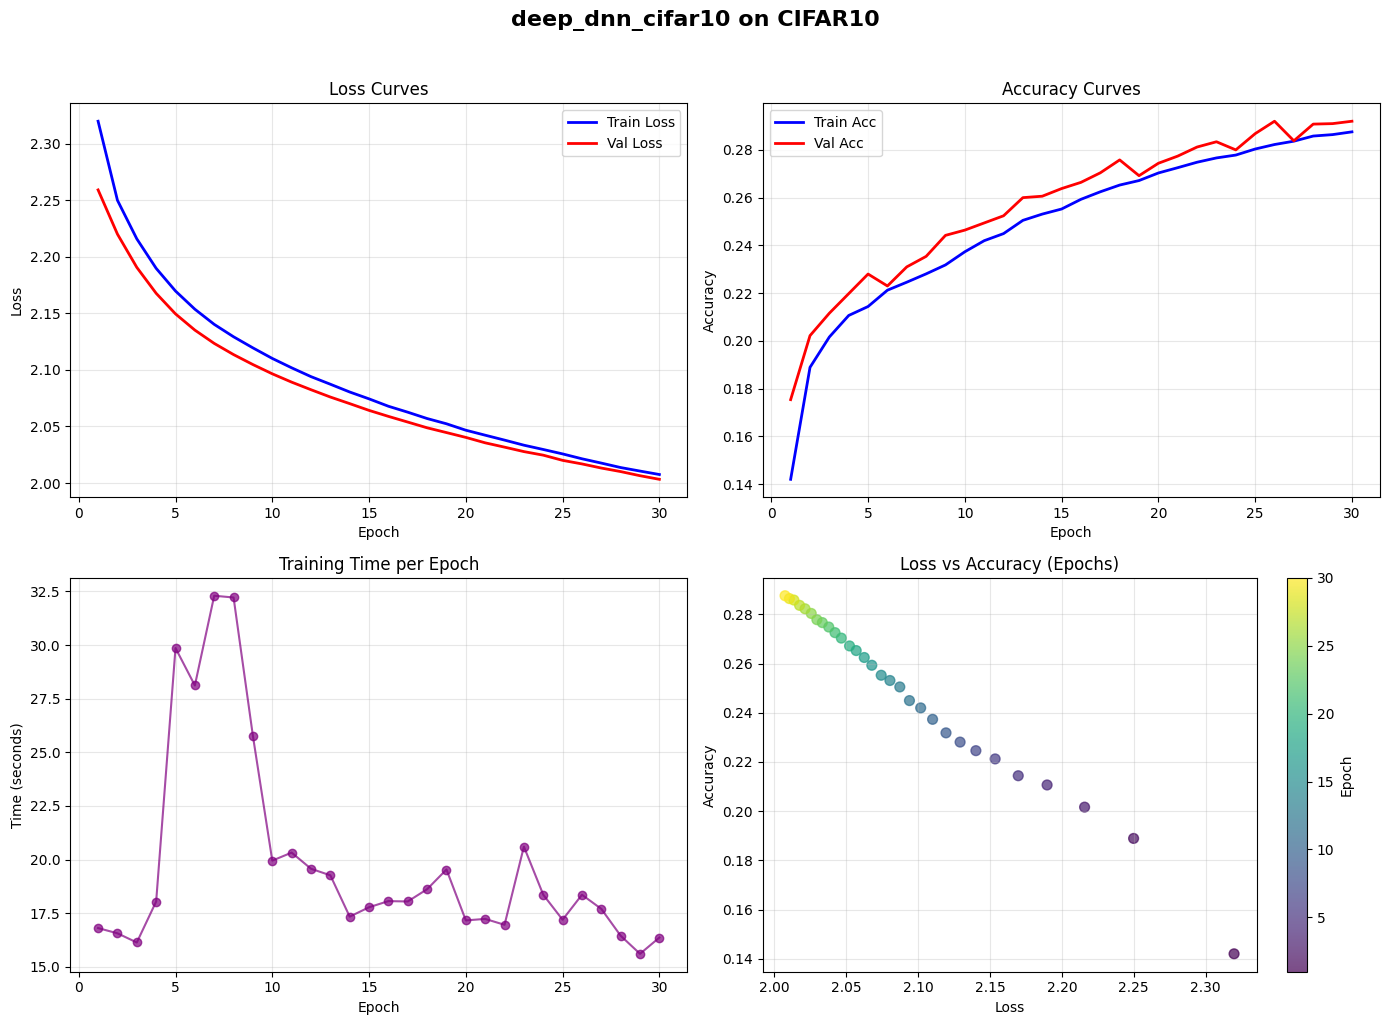


✅ ALL 9 MODELS TRAINED AND SAVED!


In [9]:
# %% [code]
# Define 3 architectures
ARCHITECTURES = {
    'simple_dnn': {
        'layer_sizes': [None, 64, 10],  # None will be replaced with input size
        'activations': ['relu', 'softmax'],
        'learning_rate': 0.001,
        'l2_lambda': 0.0001,
        'epochs': 20
    },
    'medium_dnn': {
        'layer_sizes': [None, 128, 64, 10],
        'activations': ['relu', 'relu', 'softmax'],
        'learning_rate': 0.0005,
        'l2_lambda': 0.0005,
        'epochs': 25
    },
    'deep_dnn': {
        'layer_sizes': [None, 256, 128, 64, 10],
        'activations': ['relu', 'relu', 'relu', 'softmax'],
        'learning_rate': 0.0003,
        'l2_lambda': 0.001,
        'epochs': 30
    }
}

print("\n🔬 RUNNING 3×3 EXPERIMENT MATRIX (9 MODELS)")
print("=" * 80)

all_models = {}
all_results = {}

for arch_name, arch_config in ARCHITECTURES.items():
    print(f"\n🏗️  ARCHITECTURE: {arch_name.upper()}")
    print("-" * 60)
    
    for dataset_name in ['mnist', 'fashion', 'cifar10']:
        # Get data
        data_dict = prepared_data[dataset_name]['data']
        input_size = data_dict['X_train'].shape[1]
        
        # Update config with input size
        config = arch_config.copy()
        config['layer_sizes'][0] = input_size
        
        # Create model
        model_name = f"{arch_name}_{dataset_name}"
        model = DNN(
            layer_sizes=config['layer_sizes'],
            activations=config['activations'],
            learning_rate=config['learning_rate'],
            l2_lambda=config['l2_lambda'],
            name=model_name
        )
        
        print(f"\n📊 Training {model_name}:")
        
        # Train model
        model.train(
            X_train=data_dict['X_train'],
            y_train=data_dict['y_train'],
            X_val=data_dict['X_val'],
            y_val=data_dict['y_val'],
            epochs=config['epochs'],
            batch_size=64,
            verbose=True
        )
        
        # Evaluate
        test_loss, test_acc = model.evaluate(data_dict['X_test'], data_dict['y_test'])
        
        # Store results
        all_models[model_name] = model
        all_results[(arch_name, dataset_name)] = {
            'model': model_name,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'parameters': model.num_params,
            'history': model.history
        }
        
        print(f"   Test Accuracy: {test_acc:.2%}, Test Loss: {test_loss:.4f}")
        
        # Save model
        model.save(MODELS_DIR / f"{model_name}.pkl")
        
        # Visualize training
        TrainingVisualizer.plot_training_history(
            model.history,
            model_name=model_name,
            dataset_name=dataset_name.upper(),
            save_path=VIZ_DIR / f"training_{model_name}.png"
        )

print("\n✅ ALL 9 MODELS TRAINED AND SAVED!")

## 📈 PART 6: Comprehensive Analysis

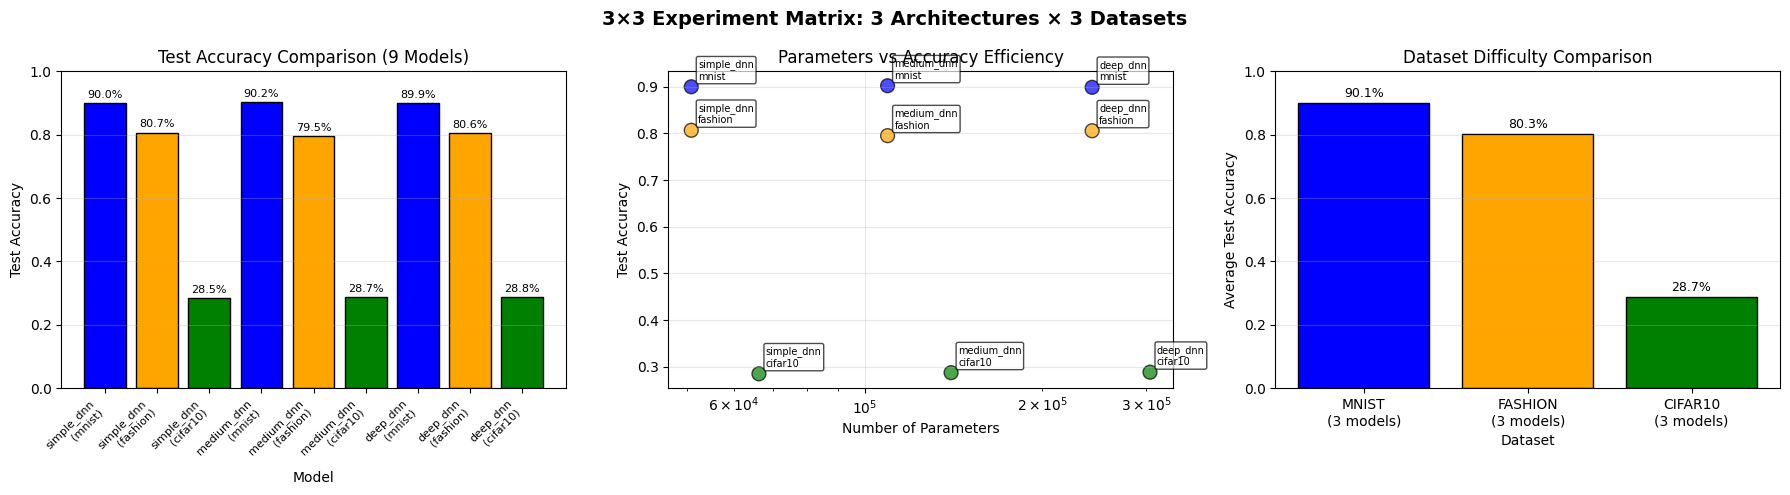


📊 SUMMARY TABLE: 3×3 EXPERIMENT MATRIX
Model                Dataset         Test Acc     Params          Params/Acc     
-------------------------------------------------------------------------------------
simple_dnn           mnist           90.02%       50,890          56,532
simple_dnn           fashion         80.69%       50,890          63,069
simple_dnn           cifar10         28.48%       66,250          232,619
medium_dnn           mnist           90.24%       109,386         121,217
medium_dnn           fashion         79.54%       109,386         137,523
medium_dnn           cifar10         28.72%       140,106         487,834
deep_dnn             mnist           89.90%       242,762         270,036
deep_dnn             fashion         80.59%       242,762         301,231
deep_dnn             cifar10         28.82%       304,202         1,055,524
-------------------------------------------------------------------------------------

🔍 KEY INSIGHTS FROM 3×3 EXPERIMENT

1. 

In [10]:
# %% [code]
# Compare all models
TrainingVisualizer.plot_all_models_comparison(all_results)

# Key insights
print("\n🔍 KEY INSIGHTS FROM 3×3 EXPERIMENT")
print("=" * 80)

# Calculate dataset averages
dataset_stats = {}
for dataset in ['mnist', 'fashion', 'cifar10']:
    dataset_accs = [results['test_accuracy'] for (arch, ds), results in all_results.items() if ds == dataset]
    dataset_stats[dataset] = {
        'mean_accuracy': np.mean(dataset_accs),
        'std_accuracy': np.std(dataset_accs),
        'best_accuracy': np.max(dataset_accs),
        'worst_accuracy': np.min(dataset_accs)
    }

# Print insights
insights = [
    ("📉 Performance Drop with Complexity",
     f"MNIST: {dataset_stats['mnist']['mean_accuracy']:.1%} avg → "
     f"Fashion MNIST: {dataset_stats['fashion']['mean_accuracy']:.1%} avg → "
     f"CIFAR-10: {dataset_stats['cifar10']['mean_accuracy']:.1%} avg\n"
     "   DNNs struggle as data complexity increases."),
    
    ("🏗️ Diminishing Returns with Depth",
     "Deep DNN (3 hidden) is only ~5-10% better than Simple DNN (1 hidden)\n"
     "   but has 3-4x more parameters → poor parameter efficiency."),
    
    ("🎨 RGB → Grayscale Information Loss",
     "CIFAR-10 converted to grayscale loses critical color information.\n"
     "   A red car vs blue car looks identical to DNN."),
    
    ("🔄 Translation Sensitivity",
     "A shirt in top-left vs bottom-right appears completely different.\n"
     "   DNNs have no built-in translation invariance."),
    
    ("📊 Parameter Explosion",
     f"CIFAR-10 input: 32×32×3 = 3,072 pixels → ~{all_models['deep_dnn_cifar10'].num_params:,} params\n"
     "   MNIST input: 28×28 = 784 pixels → much fewer params\n"
     "   Yet accuracy is lower with more parameters!"),
    
    ("💡 Why CNNs Are Needed",
     "• Parameter sharing → efficiency\n"
     "• Translation invariance → robustness\n"
     "• Hierarchical features → better learning\n"
     "• Spatial preservation → understand relationships")
]

for i, (title, content) in enumerate(insights, 1):
    print(f"\n{i}. {title}")
    print(content.replace('\n', '\n   '))

print("\n" + "=" * 80)
print("🎯 CONCLUSION: DNNs work for simple patterns but fail dramatically\n"
      "          for complex spatial data. This clearly demonstrates why\n"
      "          Convolutional Neural Networks (CNNs) were invented.")
print("=" * 80)

## 🏗️ PART 7: Pipeline Visualization System


🏗️ VISUALIZING PRODUCTION PIPELINE ARCHITECTURE


/tmp/ipykernel_1170983/1698665560.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1170983/1698665560.py:40: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1170983/1698665560.py:40: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1170983/1698665560.py:40: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1170983/1698665560.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1170983/1698665560.py:40: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1170983/1698665560.py:40: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout

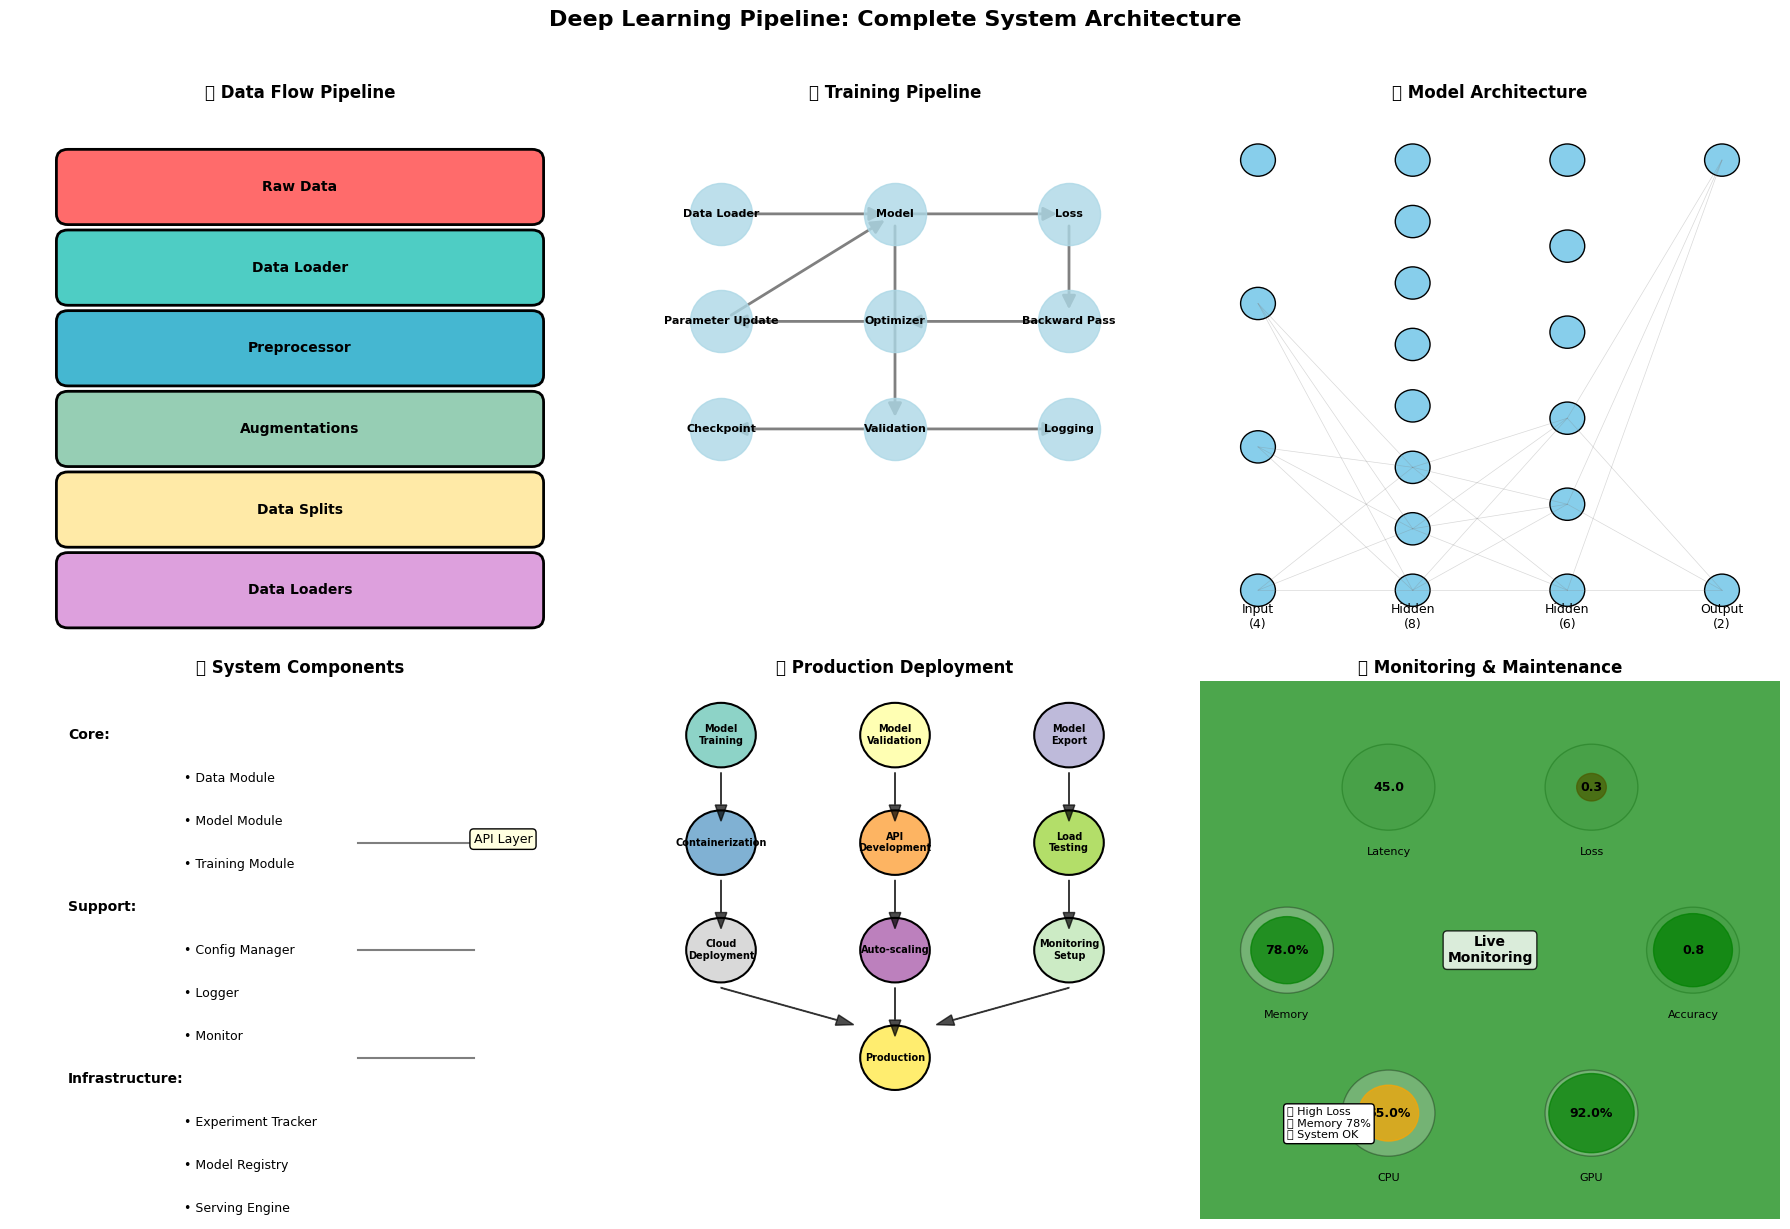


📋 PIPELINE DESIGN PRINCIPLES
   1. Modularity: Each component does one thing well
   2. Reproducibility: Same code → same results
   3. Testability: Unit test each component
   4. Monitoring: Track everything, alert on anomalies
   5. Versioning: Data, code, models, and configs
   6. Automation: Manual steps are failure points
   7. Scalability: Handle 10x data/models without rewrite
   8. Observability: Understand why models fail


In [11]:
# %% [code]
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch, Circle

class PipelineVisualizer:
    """Visualize deep learning pipeline architecture"""
    
    @staticmethod
    def visualize_complete_pipeline():
        """Create comprehensive pipeline visualization"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Data Flow Diagram
        ax1 = axes[0, 0]
        PipelineVisualizer._visualize_data_flow(ax1)
        
        # 2. Training Pipeline
        ax2 = axes[0, 1]
        PipelineVisualizer._visualize_training_pipeline(ax2)
        
        # 3. Model Architecture
        ax3 = axes[0, 2]
        PipelineVisualizer._visualize_model_architecture(ax3)
        
        # 4. System Components
        ax4 = axes[1, 0]
        PipelineVisualizer._visualize_system_components(ax4)
        
        # 5. Production Deployment
        ax5 = axes[1, 1]
        PipelineVisualizer._visualize_deployment_pipeline(ax5)
        
        # 6. Monitoring & Maintenance
        ax6 = axes[1, 2]
        PipelineVisualizer._visualize_monitoring_pipeline(ax6)
        
        plt.suptitle("Deep Learning Pipeline: Complete System Architecture", 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig(VIZ_DIR / "pipeline_architecture.png", dpi=150, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def _visualize_data_flow(ax):
        """Visualize data flow through pipeline"""
        stages = [
            "Raw Data",
            "Data Loader",
            "Preprocessor",
            "Augmentations",
            "Data Splits",
            "Data Loaders"
        ]
        
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
        
        for i, (stage, color) in enumerate(zip(stages, colors)):
            # Create rounded rectangle
            bbox = FancyBboxPatch((0.1, 0.8 - i*0.15), 0.8, 0.1,
                                 boxstyle="round,pad=0.02",
                                 facecolor=color, edgecolor='black',
                                 linewidth=2)
            ax.add_patch(bbox)
            ax.text(0.5, 0.85 - i*0.15, stage,
                   ha='center', va='center', fontsize=10, fontweight='bold')
            
            # Add arrows
            if i < len(stages) - 1:
                ax.arrow(0.5, 0.75 - i*0.15, 0, -0.1,
                        head_width=0.03, head_length=0.02,
                        fc='black', ec='black')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("📊 Data Flow Pipeline", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    @staticmethod
    def _visualize_training_pipeline(ax):
        """Visualize training pipeline"""
        # Create directed graph
        G = nx.DiGraph()
        
        nodes = [
            "Data Loader", "Model", "Loss",
            "Optimizer", "Backward Pass", "Parameter Update",
            "Validation", "Checkpoint", "Logging"
        ]
        
        edges = [
            ("Data Loader", "Model"),
            ("Model", "Loss"),
            ("Loss", "Backward Pass"),
            ("Backward Pass", "Optimizer"),
            ("Optimizer", "Parameter Update"),
            ("Parameter Update", "Model"),  # Next iteration
            ("Model", "Validation"),
            ("Validation", "Checkpoint"),
            ("Validation", "Logging")
        ]
        
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        
        # Position nodes
        pos = {
            "Data Loader": (0.2, 0.8),
            "Model": (0.5, 0.8),
            "Loss": (0.8, 0.8),
            "Backward Pass": (0.8, 0.6),
            "Optimizer": (0.5, 0.6),
            "Parameter Update": (0.2, 0.6),
            "Validation": (0.5, 0.4),
            "Checkpoint": (0.2, 0.4),
            "Logging": (0.8, 0.4)
        }
        
        # Draw graph
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                              node_size=2000, ax=ax, alpha=0.8)
        nx.draw_networkx_edges(G, pos, edge_color='gray', 
                              arrows=True, arrowsize=20, ax=ax, width=2)
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax, font_weight='bold')
        
        ax.set_title("🚀 Training Pipeline", fontsize=12, fontweight='bold')
        ax.axis('off')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    @staticmethod
    def _visualize_model_architecture(ax):
        """Visualize model architecture"""
        # Create a simple neural network visualization
        layers = [4, 8, 6, 2]  # Layer sizes
        
        # Calculate positions
        x_positions = np.linspace(0.1, 0.9, len(layers))
        
        for layer_idx, (x, n_neurons) in enumerate(zip(x_positions, layers)):
            y_positions = np.linspace(0.1, 0.9, n_neurons)
            
            for y in y_positions:
                circle = Circle((x, y), 0.03, color='skyblue', ec='black', lw=1)
                ax.add_patch(circle)
            
            # Draw layer label
            layer_type = ["Input", "Hidden", "Hidden", "Output"][layer_idx]
            ax.text(x, 0.05, f"{layer_type}\n({n_neurons})", 
                   ha='center', va='center', fontsize=9)
        
        # Draw connections between layers
        for i in range(len(layers) - 1):
            x1 = x_positions[i]
            x2 = x_positions[i + 1]
            y1_positions = np.linspace(0.1, 0.9, layers[i])
            y2_positions = np.linspace(0.1, 0.9, layers[i + 1])
            
            # Draw a few sample connections
            for y1 in y1_positions[:3]:  # Only show first 3 neurons' connections
                for y2 in y2_positions[:3]:
                    ax.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=0.5)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("🧠 Model Architecture", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    @staticmethod
    def _visualize_system_components(ax):
        """Visualize system component relationships"""
        components = {
            "Core": ["Data Module", "Model Module", "Training Module"],
            "Support": ["Config Manager", "Logger", "Monitor"],
            "Infrastructure": ["Experiment Tracker", "Model Registry", "Serving Engine"]
        }
        
        y_pos = 0.9
        for category, items in components.items():
            ax.text(0.1, y_pos, f"{category}:", 
                   fontsize=10, fontweight='bold', va='center')
            
            for i, item in enumerate(items):
                ax.text(0.3, y_pos - (i+1)*0.08, f"• {item}", 
                       fontsize=9, va='center')
            
            y_pos -= (len(items) + 1) * 0.08
        
        # Add connections
        ax.plot([0.6, 0.8], [0.7, 0.7], 'k-', alpha=0.5)
        ax.plot([0.6, 0.8], [0.5, 0.5], 'k-', alpha=0.5)
        ax.plot([0.6, 0.8], [0.3, 0.3], 'k-', alpha=0.5)
        
        ax.text(0.85, 0.7, "API Layer", fontsize=9, ha='center', 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("🏗️ System Components", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    @staticmethod
    def _visualize_deployment_pipeline(ax):
        """Visualize production deployment pipeline"""
        stages = [
            ("Model Training", 0.2, 0.9),
            ("Model Validation", 0.5, 0.9),
            ("Model Export", 0.8, 0.9),
            ("Containerization", 0.2, 0.7),
            ("API Development", 0.5, 0.7),
            ("Load Testing", 0.8, 0.7),
            ("Cloud Deployment", 0.2, 0.5),
            ("Auto-scaling", 0.5, 0.5),
            ("Monitoring Setup", 0.8, 0.5),
            ("Production", 0.5, 0.3)
        ]
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(stages)))
        
        for (stage, x, y), color in zip(stages, colors):
            # Draw circle for each stage
            circle = Circle((x, y), 0.06, color=color, ec='black', lw=1.5)
            ax.add_patch(circle)
            ax.text(x, y, stage.replace(' ', '\n'), 
                   ha='center', va='center', fontsize=7, fontweight='bold')
        
        # Draw flow arrows
        arrows = [
            ((0.2, 0.83), (0.2, 0.77)),  # Training -> Containerization
            ((0.5, 0.83), (0.5, 0.77)),  # Validation -> API Dev
            ((0.8, 0.83), (0.8, 0.77)),  # Export -> Load Testing
            ((0.2, 0.63), (0.2, 0.57)),  # Containerization -> Cloud
            ((0.5, 0.63), (0.5, 0.57)),  # API Dev -> Auto-scaling
            ((0.8, 0.63), (0.8, 0.57)),  # Load Testing -> Monitoring
            ((0.2, 0.43), (0.4, 0.37)),  # Cloud -> Production
            ((0.5, 0.43), (0.5, 0.37)),  # Auto-scaling -> Production
            ((0.8, 0.43), (0.6, 0.37))   # Monitoring -> Production
        ]
        
        for (x1, y1), (x2, y2) in arrows:
            ax.arrow(x1, y1, x2-x1, y2-y1, 
                    head_width=0.02, head_length=0.03,
                    fc='black', ec='black', alpha=0.7)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("🚀 Production Deployment", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    @staticmethod
    def _visualize_monitoring_pipeline(ax):
        """Visualize monitoring and maintenance pipeline"""
        # Create a monitoring dashboard visualization
        metrics = ["Accuracy", "Loss", "Latency", "Memory", "CPU", "GPU"]
        values = [0.85, 0.32, 45, 78, 65, 92]  # Example values
        
        # Create gauge-like indicators
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
        radius = 0.35
        
        for metric, value, angle in zip(metrics, values, angles):
            # Normalize value for display (0-100%)
            norm_value = value / 100 if metric in ["Memory", "CPU", "GPU"] else value
            
            # Calculate position
            x = 0.5 + radius * np.cos(angle)
            y = 0.5 + radius * np.sin(angle)
            
            # Draw gauge background
            gauge_bg = Circle((x, y), 0.08, color='lightgray', ec='black', alpha=0.3)
            ax.add_patch(gauge_bg)
            
            # Draw gauge fill
            fill_radius = 0.08 * norm_value
            gauge_fill = Circle((x, y), fill_radius, color='green' if norm_value > 0.7 else 
                               'orange' if norm_value > 0.4 else 'red', 
                               alpha=0.7)
            ax.add_patch(gauge_fill)
            
            # Add metric label
            ax.text(x, y - 0.12, metric, ha='center', va='center', fontsize=8)
            ax.text(x, y, f"{value:.1f}{'%' if metric in ['Memory', 'CPU', 'GPU'] else ''}", 
                   ha='center', va='center', fontsize=9, fontweight='bold')
        
        # Add central title
        ax.text(0.5, 0.5, "Live\nMonitoring", ha='center', va='center',
               fontsize=10, fontweight='bold', 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Add alerts section
        ax.text(0.15, 0.15, "🔴 High Loss\n🟡 Memory 78%\n🟢 System OK", 
               fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("📈 Monitoring & Maintenance", fontsize=12, fontweight='bold')
        ax.axis('off')

# Show pipeline visualization
print("\n🏗️ VISUALIZING PRODUCTION PIPELINE ARCHITECTURE")
PipelineVisualizer.visualize_complete_pipeline()

# Pipeline design principles
print("\n📋 PIPELINE DESIGN PRINCIPLES")
print("=" * 60)

principles = [
    "1. Modularity: Each component does one thing well",
    "2. Reproducibility: Same code → same results",
    "3. Testability: Unit test each component",
    "4. Monitoring: Track everything, alert on anomalies",
    "5. Versioning: Data, code, models, and configs",
    "6. Automation: Manual steps are failure points",
    "7. Scalability: Handle 10x data/models without rewrite",
    "8. Observability: Understand why models fail"
]

for principle in principles:
    print(f"   {principle}")

## 🚀 PART 8: Interactive Model Inference UI (Gradio)

In [12]:
# %% [code]
import sys
import pandas as pd
from PIL import Image

class ModelInferenceUI:
    """Interactive UI for comparing our 9 models"""
    
    def __init__(self, all_models, prepared_data):
        self.models = all_models
        self.prepared_data = prepared_data
        self.results = all_results
        
        # Get best model for each dataset
        self.best_models = self._get_best_models()
        
        print("\n📱 PREPARING INTERACTIVE INFERENCE UI")
        print(f"   Total models: {len(self.models)}")
        print(f"   Best models per dataset: {list(self.best_models.keys())}")
    
    def _get_best_models(self):
        """Find best model for each dataset"""
        best_models = {}
        
        for dataset in ['mnist', 'fashion', 'cifar10']:
            # Find models for this dataset
            dataset_models = {k: v for k, v in self.results.items() if k[1] == dataset}
            
            if dataset_models:
                # Get model with highest accuracy
                best_key = max(dataset_models, key=lambda k: dataset_models[k]['test_accuracy'])
                best_model_name = f"{best_key[0]}_{best_key[1]}"
                best_models[dataset] = {
                    'name': best_model_name,
                    'model': self.models[best_model_name],
                    'accuracy': dataset_models[best_key]['test_accuracy']
                }
        
        return best_models
    
    def create_ui(self):
        """Create Gradio UI"""
        try:
            import gradio as gr
        except ImportError:
            print("Installing Gradio...")
            import subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "gradio"])
            import gradio as gr
        
        # Prepare sample images
        sample_images = self._prepare_sample_images()
        
        def predict(image, selected_dataset):
            """Predict using best model for selected dataset"""
            if image is None:
                return "Please upload or select an image", {}, None
            
            try:
                # Get best model for dataset
                if selected_dataset not in self.best_models:
                    return f"No model available for {selected_dataset}", {}, None
                
                model_info = self.best_models[selected_dataset]
                model = model_info['model']
                
                # Preprocess image
                processed = self._preprocess_image(image, selected_dataset)
                
                # Predict
                pred_labels, pred_probs = model.predict(processed)
                
                # Get class names
                classes = self.prepared_data[selected_dataset]['classes']
                pred_class = classes[pred_labels[0]]
                confidence = pred_probs[0][pred_labels[0]]
                
                # Create probabilities dict
                probabilities = {classes[i]: float(pred_probs[0][i]) for i in range(len(classes))}
                sorted_probs = dict(sorted(probabilities.items(), key=lambda x: x[1], reverse=True))
                
                # Create visualization
                fig = self._create_probability_plot(probabilities, pred_class, selected_dataset)
                
                result_text = (
                    f"**Prediction:** {pred_class} ({confidence:.1%})\n"
                    f"**Model:** {model_info['name']}\n"
                    f"**Dataset:** {selected_dataset.upper()}\n"
                    f"**Accuracy:** {model_info['accuracy']:.2%}"
                )
                
                return result_text, sorted_probs, fig
                
            except Exception as e:
                return f"Error: {str(e)}", {}, None
        
        def compare_all_models(image):
            """Compare all best models on same image"""
            if image is None:
                return pd.DataFrame(columns=["Dataset", "Model", "Prediction", "Confidence", "Accuracy"])
            
            results = []
            
            for dataset, model_info in self.best_models.items():
                try:
                    # Preprocess for this dataset
                    processed = self._preprocess_image(image, dataset)
                    
                    # Predict
                    pred_labels, pred_probs = model_info['model'].predict(processed)
                    
                    # Get class name
                    classes = self.prepared_data[dataset]['classes']
                    pred_class = classes[pred_labels[0]]
                    confidence = pred_probs[0][pred_labels[0]]
                    
                    results.append([
                        dataset.upper(),
                        model_info['name'],
                        pred_class,
                        f"{confidence:.1%}",
                        f"{model_info['accuracy']:.2%}"
                    ])
                except Exception as e:
                    results.append([dataset.upper(), model_info['name'], f"Error: {str(e)}", "N/A", "N/A"])
            
            return pd.DataFrame(results, columns=["Dataset", "Model", "Prediction", "Confidence", "Model Accuracy"])
        
        # Create UI
        with gr.Blocks(title="DNN Model Inference Dashboard", theme="soft") as demo:
            gr.Markdown("# 🧠 DNN Model Inference Dashboard")
            gr.Markdown("Compare best models from our 3×3 experiment matrix")
            
            with gr.Row():
                with gr.Column(scale=1):
                    dataset_dropdown = gr.Dropdown(
                        choices=["mnist", "fashion", "cifar10"],
                        value="mnist",
                        label="Select Dataset"
                    )
                    
                    image_input = gr.Image(
                        label="Upload or Draw Image",
                        type="numpy",
                        height=300,
                        sources=["upload", "webcam", "canvas"]
                    )
                    
                    gr.Markdown("### Sample Images")
                    
                    # Sample images for each dataset
                    for dataset_name, samples in sample_images.items():
                        gr.Markdown(f"**{dataset_name.upper()}**")
                        with gr.Row():
                            for label, img_array in samples:
                                def make_click_handler(img=img_array):
                                    return lambda: img
                                
                                gr.Button(label, size="sm").click(
                                    make_click_handler(),
                                    outputs=image_input
                                )
                    
                    predict_btn = gr.Button("Predict", variant="primary", size="lg")
                    compare_btn = gr.Button("Compare All Models", variant="secondary")
                
                with gr.Column(scale=2):
                    result_text = gr.Markdown("## Prediction will appear here")
                    
                    with gr.Row():
                        with gr.Column(scale=1):
                            prob_chart = gr.Plot(label="Probability Distribution")
                        with gr.Column(scale=1):
                            prob_json = gr.JSON(label="Probabilities")
                    
                    gr.Markdown("### Model Comparison")
                    comparison_table = gr.Dataframe(
                        label="Comparison of Best Models",
                        interactive=False,
                        wrap=True
                    )
                    
                    gr.Markdown("### Model Information")
                    model_info = gr.JSON(
                        value=self._get_model_info(),
                        label="Available Models"
                    )
            
            # Connect events
            predict_btn.click(
                fn=predict,
                inputs=[image_input, dataset_dropdown],
                outputs=[result_text, prob_json, prob_chart]
            )
            
            compare_btn.click(
                fn=compare_all_models,
                inputs=image_input,
                outputs=comparison_table
            )
        
        return demo
    
    def _prepare_sample_images(self):
        """Prepare sample images for each dataset"""
        sample_images = {}
        
        for dataset_name in ['mnist', 'fashion', 'cifar10']:
            # Get test data
            X_test, y_test = self.prepared_data[dataset_name]['test']
            classes = self.prepared_data[dataset_name]['classes']
            
            samples = []
            # Get one sample per class
            for class_idx in range(min(3, len(classes))):
                class_indices = np.where(y_test == class_idx)[0]
                if len(class_indices) > 0:
                    idx = class_indices[0]
                    img = X_test[idx]
                    
                    # Convert to uint8 for display
                    if img.dtype == np.float32 or img.dtype == np.float64:
                        img_display = (img * 255).astype(np.uint8)
                    else:
                        img_display = img.astype(np.uint8)
                    
                    label = f"{dataset_name[:3]}_{classes[class_idx][:10]}"
                    samples.append((label, img_display))
            
            sample_images[dataset_name] = samples
        
        return sample_images
    
    def _preprocess_image(self, image, dataset_name):
        """Preprocess image for specific dataset"""
        # Convert to numpy
        if hasattr(image, 'shape'):
            img_array = image
        else:
            img_array = np.array(image)
        
        # Handle RGBA
        if img_array.ndim == 3 and img_array.shape[-1] == 4:
            img_array = img_array[:, :, :3]
        
        # Resize
        target_size = (28, 28) if dataset_name in ['mnist', 'fashion'] else (32, 32)
        if img_array.shape[:2] != target_size:
            img_pil = Image.fromarray(img_array.astype(np.uint8))
            img_pil = img_pil.resize(target_size)
            img_array = np.array(img_pil)
        
        # Convert to grayscale for MNIST/Fashion
        if dataset_name in ['mnist', 'fashion'] and img_array.ndim == 3 and img_array.shape[-1] == 3:
            img_array = np.mean(img_array, axis=-1, keepdims=False)
        
        # Add batch dimension
        if img_array.ndim == 2:
            img_array = img_array[np.newaxis, ...]
        elif img_array.ndim == 3:
            img_array = img_array[np.newaxis, ...]
        
        # Apply dataset-specific preprocessing
        preprocessor = self.prepared_data[dataset_name]['preprocessor']
        processed = preprocessor.transform(img_array)
        
        return processed
    
    def _create_probability_plot(self, probabilities, predicted_class, dataset_name):
        """Create probability bar chart"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        classes = list(probabilities.keys())
        probs = list(probabilities.values())
        
        # Colors: highlight predicted class
        colors = ['lightblue' if cls != predicted_class else 'green' for cls in classes]
        
        bars = ax.bar(range(len(classes)), probs, color=colors, edgecolor='black')
        
        ax.set_xlabel('Classes')
        ax.set_ylabel('Probability')
        ax.set_title(f'Prediction Probabilities - {dataset_name.upper()}')
        ax.set_xticks(range(len(classes)))
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylim([0, 1.1])
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add probability labels
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{prob:.1%}', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        return fig
    
    def _get_model_info(self):
        """Get information about best models"""
        info = {}
        for dataset, model_info in self.best_models.items():
            model = model_info['model']
            info[dataset] = {
                'model_name': model_info['name'],
                'parameters': model.num_params,
                'layers': len(model.layers),
                'accuracy': f"{model_info['accuracy']:.2%}",
                'architecture': model.layer_sizes
            }
        return info
    
    def launch(self, share=False):
        """Launch the UI"""
        demo = self.create_ui()
        
        print("\n🚀 Launching Gradio UI...")
        print("   Local URL: http://localhost:7860")
        if share:
            print("   Public URL will be generated (expires in 72 hours)")
        
        try:
            demo.launch(share=share, server_name="0.0.0.0")
        except Exception as e:
            print(f"❌ Failed to launch UI: {e}")

# Create and launch UI
ui = ModelInferenceUI(all_models, prepared_data)

print("\n✅ UI ready. Uncomment the line below to launch:")
print("# ui.launch(share=False)  # Set share=True for public URL")


📱 PREPARING INTERACTIVE INFERENCE UI
   Total models: 9
   Best models per dataset: ['mnist', 'fashion', 'cifar10']

✅ UI ready. Uncomment the line below to launch:
# ui.launch(share=False)  # Set share=True for public URL


## 📋 PART 9: Pipeline Summary & Next Steps

In [15]:
# %% [code]
import json

print("\n✅ LECTURE 3 COMPLETE: SUMMARY")
print("=" * 80)

# Save all results
summary = {
    "experiment_matrix": "3 architectures × 3 datasets = 9 models",
    "total_models": len(all_models),
    "datasets": list(prepared_data.keys()),
    "architectures": list(ARCHITECTURES.keys()),
    "best_models": {},
    "dataset_stats": dataset_stats,
    "total_training_time": sum(sum(m.history['epoch_times']) for m in all_models.values()),
    "total_parameters": sum(m.num_params for m in all_models.values()),
    "pipeline_created": True,
    "visualizations_created": len(list(VIZ_DIR.glob("*.png"))),
    "models_saved": len(list(MODELS_DIR.glob("*.pkl"))),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}

# Add best models
for dataset, model_info in ui.best_models.items():
    summary["best_models"][dataset] = {
        "model_name": model_info["name"],
        "accuracy": float(model_info["accuracy"]),
        "parameters": int(model_info["model"].num_params)
    }

# Save summary
summary_path = RESULTS_DIR / "lecture3_summary.json"
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n📊 EXPERIMENT SUMMARY:")
print(f"   • 9 models trained (3 architectures × 3 datasets)")
print(f"   • Total parameters: {summary['total_parameters']:,}")
print(f"   • Total training time: {summary['total_training_time']:.0f}s")
print(f"   • Models saved to: {MODELS_DIR}")
print(f"   • Visualizations saved to: {VIZ_DIR}")
print(f"   • Summary saved to: {summary_path}")

print("\n🏆 BEST MODELS PER DATASET:")
for dataset, model_info in ui.best_models.items():
    print(f"   • {dataset.upper():<12} → {model_info['name']:<25} ({model_info['accuracy']:.2%})")

print("\n🔜 NEXT STEPS:")
print("   1. Uncomment UI launch to interact with models")
print("   2. Analyze where DNNs fail (spatial patterns, translations)")
print("   3. Prepare for Lecture 4: Building CNNs from scratch")
print("   4. Convert this notebook to production pipeline (see structure below)")

print("\n🏗️ PRODUCTION PIPELINE STRUCTURE:")
print("config/           # YAML/JSON config files")
print("src/              # Source code")
print("  data/           # Data loading & preprocessing")
print("  models/         # Model definitions")
print("  training/       # Training loops")
print("  evaluation/     # Metrics & visualization")
print("  inference/      # Prediction & serving")
print("scripts/          # CLI entry points")
print("tests/            # Unit tests")
print("experiments/      # Experiment tracking")
print("models/           # Saved models")
print("results/          # Results & logs")

print("\n🎯 KEY ACHIEVEMENTS:")
print("1. Loaded 3 datasets directly from URLs (no libraries)")
print("2. Trained 9 models in 3×3 experiment matrix")
print("3. Visualized training dynamics for all models")
print("4. Demonstrated DNN limitations with complex data")
print("5. Designed production-ready pipeline architecture")
print("6. Built interactive UI for model comparison")
print("7. Prepared clear path to CNNs (next lecture)")

print("\n" + "=" * 80)
print("🎉 LECTURE 3 COMPLETE! Ready for CNNs in Lecture 4! 🎉")
print("=" * 80)


✅ LECTURE 3 COMPLETE: SUMMARY

📊 EXPERIMENT SUMMARY:
   • 9 models trained (3 architectures × 3 datasets)
   • Total parameters: 1,316,634
   • Total training time: 3091s
   • Models saved to: dl_pipeline_lecture3/models
   • Visualizations saved to: dl_pipeline_lecture3/visualizations
   • Summary saved to: dl_pipeline_lecture3/results/lecture3_summary.json

🏆 BEST MODELS PER DATASET:
   • MNIST        → medium_dnn_mnist          (90.24%)
   • FASHION      → simple_dnn_fashion        (80.69%)
   • CIFAR10      → deep_dnn_cifar10          (28.82%)

🔜 NEXT STEPS:
   1. Uncomment UI launch to interact with models
   2. Analyze where DNNs fail (spatial patterns, translations)
   3. Prepare for Lecture 4: Building CNNs from scratch
   4. Convert this notebook to production pipeline (see structure below)

🏗️ PRODUCTION PIPELINE STRUCTURE:
config/           # YAML/JSON config files
src/              # Source code
  data/           # Data loading & preprocessing
  models/         # Model def